***Proyecto: Diabetes 130-US hospitals for years 1999-2008***
<br>Jesus Antonio Villarraga

La solución del presente proyecto considera la metodología CRISP-DM (Cross-Industry Standard Process for Data Mining). El cual es un marco ampliamente utilizado para proyectos de ciencia de datos que involucran minería de datos y análisis predictivo. considera 6 etapas.<br>
1. Comprensión del Negocio.
2. Comprensión de los Datos.
3. Preparación de Datos.
4. Modelado.
5. Evaluación.
6. Despliegue.

# 1. Comprensión del Negocio.

Estudiar y comprender la readmisión de pacientes en el contexto de la base de datos **"Diabetes 130-US hospitals for years 1999-2008"** es de suma importancia para el sistema de salud y los hospitales. La readmisión de un paciente en menos de 30 días puede indicar que el tratamiento inicial no fue completamente efectivo o que el paciente presenta condiciones de salud crónicas. Analizar estos casos brinda información sobre la calidad de la atención, la efectividad de los tratamientos y la necesidad de intervenciones de seguimiento más efectivas, lo que puede resultar en ajustes en los protocolos de atención y mejorar la gestión de los recursos hospitalarios.

Además, entender las causas de la readmisión puede llevar a la aplicación de estrategias preventivas con el objetivo de reducir la tasa de readmisión. Reducir la readmisión no solo implica un mejor manejo de la enfermedad por parte del paciente, sino también una distribución más eficiente de los recursos del hospital, evitando la congestión y reduciendo los costos asociados.

# 2. Comprensión de los Datos.

In [147]:
# Librerias
### Tratamiento de datos
import pandas as pd
import numpy as np

###Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

###Procesado y modelado
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

###Evaluación del modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

###Balanceo de data
from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

#### Función auxiliar

In [148]:
#@title Score Card (análisis de lift)
def score_card_train(Y_real, Y_pred, NumSeg):
    score_card_val = pd.DataFrame()
    if len(Y_pred.shape)==2:
        Y_pred = Y_pred[:,1]
    score_card_val['probabilidad'] = Y_pred.round(5)
    score_card_val['Y'] = Y_real
    score_card_val['decil'] = pd.qcut(score_card_val['probabilidad'], NumSeg, duplicates='drop', precision=6)

    results = score_card_val. \
        groupby(['decil']). \
        agg(Total=pd.NamedAgg('Y', lambda x: x.count()),
            Y1=pd.NamedAgg('Y', lambda x: x.sum()),
            TasaY1=pd.NamedAgg('Y', lambda x: x.mean()),
            prob_mean=pd.NamedAgg('probabilidad', lambda x: x.mean())). \
        reset_index()
    TasaTotal = results['Y1'].sum() / results['Total'].sum()
    results['lift'] = (results['TasaY1'] / TasaTotal).round(2)
    results['Part'] = (results['Total'] / results['Total'].sum())
    results['Y0'] = results['Total'] - results['Y1']
   
    # Nuevas columnas
    results['TasaY0'] = results['Y0']/results['Total']
    results['TasaAcumY0'] = 1-results['Y0'].shift(1, fill_value=0).cumsum()/results['Y0'].sum()
    results['TasaAcumY1'] = 1-results['Y1'].shift(1, fill_value=0).cumsum()/results['Y1'].sum()
    results['KS'] = (results['TasaAcumY1'] - results['TasaAcumY0']).abs()
    results['Odds'] = results['Y0'] / results['Y1']
    results['OddsAcum'] = results['Y0'].cumsum() / results['Y1'].cumsum()
    results['paraROC'] = (-results['TasaAcumY1'].diff()*results['TasaAcumY0'].rolling(2).sum()).shift(-1,fill_value=0)
    results.loc[len(results)-1, 'paraROC'] = results.loc[len(results)-1, 'TasaAcumY1'] * results.loc[len(results)-1, 'TasaAcumY0']
    results['paraGini'] = (-results['Part'].diff()*results['TasaAcumY1'].rolling(2).sum()).shift(-1,fill_value=0)
    results.loc[len(results)-1, 'paraGini'] = results.loc[len(results)-1, 'Part'] * results.loc[len(results)-1, 'TasaAcumY1']
    results = results[['decil', 'Total', 'Part',
                       'Y0', 'TasaY0', 'TasaAcumY0',
                       'Y1',  'TasaY1', 'TasaAcumY1',
                       'KS', 'Odds', 'OddsAcum',
                       'lift', 'paraROC', 'paraGini', 'prob_mean']]
   
    # Nuevo: Exporta métricas generales
    metricas = {'lift_growth': (results['lift'].diff()[1:]>0).mean(),
                'lift_last': results['lift'].iloc[-1],
                'KS': results['KS'].max(),
                'Gini': abs(results['paraGini'].sum()-1),
                'ROC': 1-results['paraROC'].sum()/2,
                'AR': 1-results['paraROC'].sum(),
                'OddsMax': results['Odds'].max(),
                'OddsMin': results['Odds'].min()
               }

    cortes = NumSeg-2
    conteo = 0
    lista_xg = []
    lista_xg.append(-1)
    for i in results['decil']:
        if conteo <= cortes:
            lista_xg.append(i.right)
        else:
            lista_xg.append(1)
        conteo = conteo + 1
    puntos_corte = lista_xg

    return results, metricas, lista_xg

def score_card_test(Y_real, Y_pred, deciles):
    score_card_val = pd.DataFrame()
    if len(Y_pred.shape)==2:
        Y_pred = Y_pred[:,1]
    score_card_val['probabilidad'] = Y_pred.round(5)
    score_card_val['Y'] = Y_real
    score_card_val['decil'] = pd.cut(score_card_val['probabilidad'], deciles,precision=6, duplicates='drop')

    results = score_card_val. \
        groupby(['decil']). \
        agg(Total=pd.NamedAgg('Y', lambda x: x.count()),
            Y1=pd.NamedAgg('Y', lambda x: x.sum()),
            TasaY1=pd.NamedAgg('Y', lambda x: x.mean()),
            prob_mean=pd.NamedAgg('probabilidad', lambda x: x.mean())). \
        reset_index()
    TasaTotal = results['Y1'].sum() / results['Total'].sum()
    results['lift'] = (results['TasaY1'] / TasaTotal).round(2)
    results['Part'] = (results['Total'] / results['Total'].sum())
    results['Y0'] = results['Total'] - results['Y1']

     # Nuevas columnas
    results['TasaY0'] = results['Y0']/results['Total']
    results['TasaAcumY0'] = 1-results['Y0'].shift(1, fill_value=0).cumsum()/results['Y0'].sum()
    results['TasaAcumY1'] = 1-results['Y1'].shift(1, fill_value=0).cumsum()/results['Y1'].sum()
    results['KS'] = (results['TasaAcumY1'] - results['TasaAcumY0']).abs()
    results['Odds'] = results['Y0'] / results['Y1']
    results['OddsAcum'] = results['Y0'].cumsum() / results['Y1'].cumsum()
    results['paraROC'] = (-results['TasaAcumY1'].diff()*results['TasaAcumY0'].rolling(2).sum()).shift(-1,fill_value=0)
    results.loc[len(results)-1, 'paraROC'] = results.loc[len(results)-1, 'TasaAcumY1'] * results.loc[len(results)-1, 'TasaAcumY0']
    results['paraGini'] = (-results['Part'].diff()*results['TasaAcumY1'].rolling(2).sum()).shift(-1,fill_value=0)
    results.loc[len(results)-1, 'paraGini'] = results.loc[len(results)-1, 'Part'] * results.loc[len(results)-1, 'TasaAcumY1']
    results = results[['decil', 'Total', 'Part',
                       'Y0', 'TasaY0', 'TasaAcumY0',
                       'Y1',  'TasaY1', 'TasaAcumY1',
                       'KS', 'Odds', 'OddsAcum',
                       'lift', 'paraROC', 'paraGini', 'prob_mean']]

    # Nuevo: Exporta métricas generales
    metricas = {'lift_growth': (results['lift'].diff()[1:]>0).mean(),
                'lift_last': results['lift'].iloc[-1],
                'KS': results['KS'].max(),
                'Gini': abs(results['paraGini'].sum()-1),
                'ROC': 1-results['paraROC'].sum()/2,
                'AR': 1-results['paraROC'].sum(),
                'OddsMax': results['Odds'].max(),
                'OddsMin': results['Odds'].min()
               }
   
    return results, metricas

**Carga del conjunto de datos**

In [149]:
df=pd.read_csv("diabetic_data.csv")
df.replace('?', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

**2.1 Identificación de valores vacios**<br>
Se dentifican los valores vacios o faltantes tanto en columna (variable) como en fila (registro)

In [150]:
# Valores vacios
Valores_perdidos = (df.isnull().sum() / len(df)) * 100

# Filtrar para mostrar solo variables con valores vacíos
variables_con_valores_vacios = Valores_perdidos[Valores_perdidos > 0]
variables_con_valores_vacios

race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

In [151]:
# Número de valores faltantes por fila
Valores_peridos_fila = df.isnull().sum(axis=1)

# Filtrar las filas que tienen más de 5 valores faltantes
filas_con_mas_de_5_valores_faltantes = df[Valores_peridos_fila > 4]
len(filas_con_mas_de_5_valores_faltantes)

28

**2.2 Valores duplicados**

In [152]:
# Encontrar filas duplicadas
filas_duplicadas = df[df.duplicated()]
len(filas_duplicadas)

0

**2.3 Distribuciones de las variables** 

Se realiza una exploración preliminar de las variables clasificadas como 'object' y 'float64'. Para las primeras, se generan diagramas de barras, mientras que para las segundas se construyen histogramas y boxplots. El objetivo es comprender el comportamiento y la distribución de cada variable, así como identificar los valores que pueden tomar.<br>
Cabe mencionar que resulta innecesario generar histogramas o boxplots para variables que contienen identificaciones. No obstante, se incluyen en esta fase inicial por el filtro que se maneja. Es fundamental recordar que esta etapa representa un análisis preliminar en el proceso.

In [153]:
#Selección de variales cualitativas
variables_cualitativas = df.select_dtypes(include=['object'])

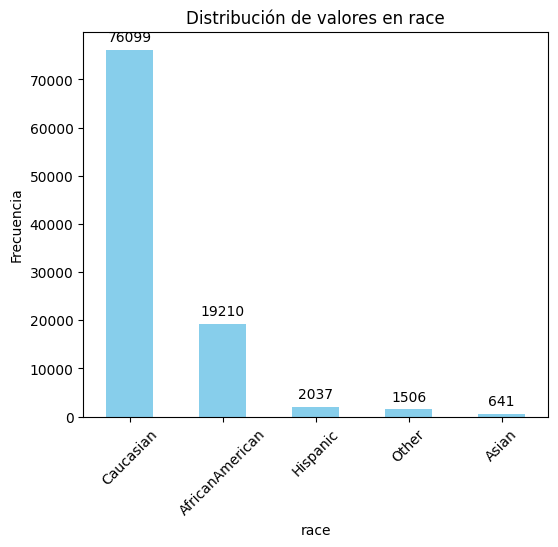

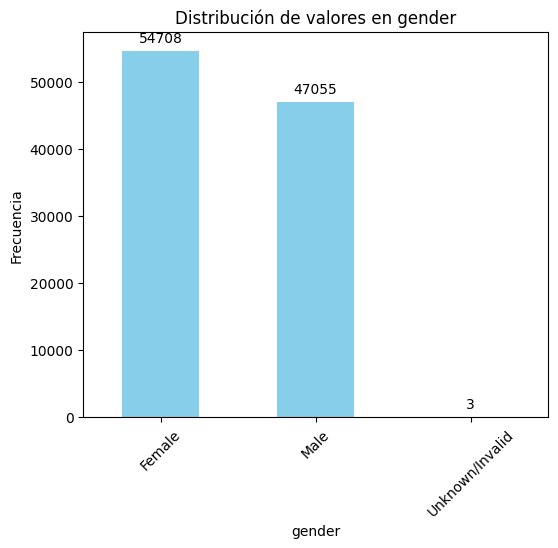

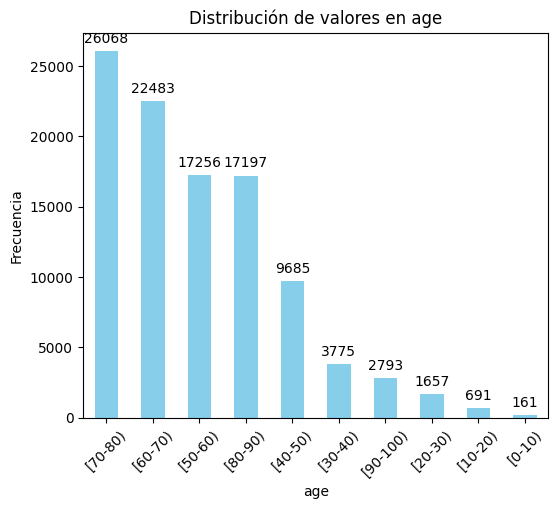

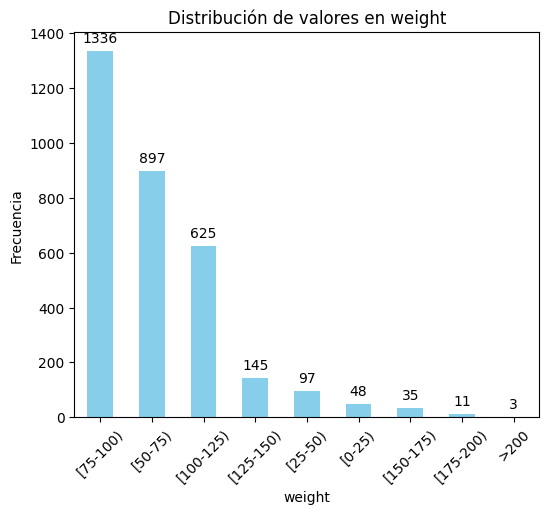

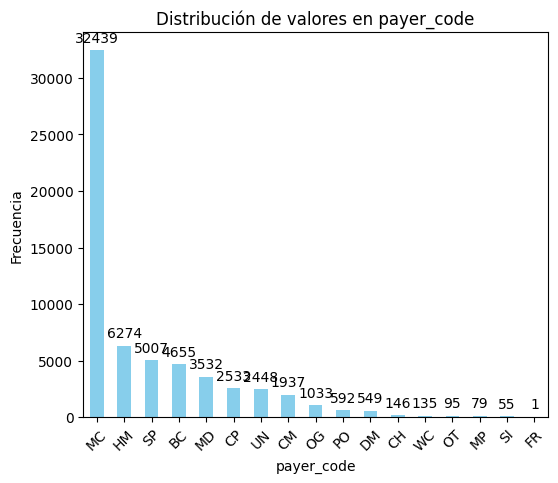

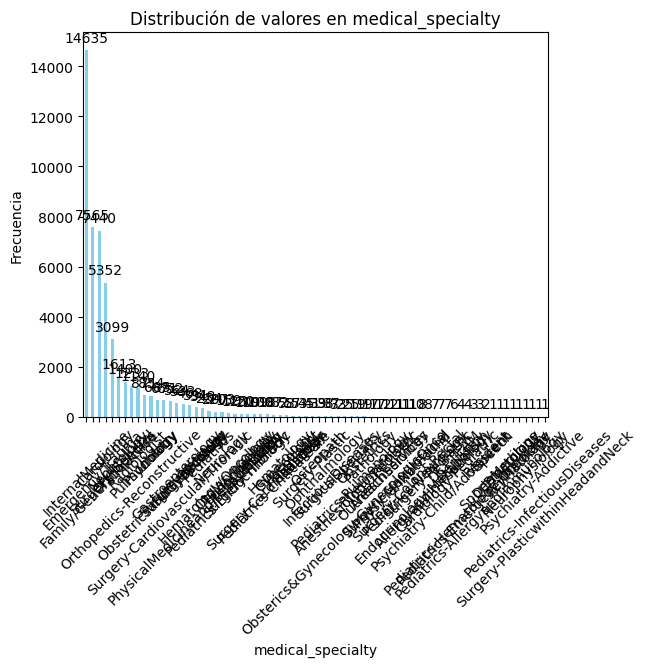

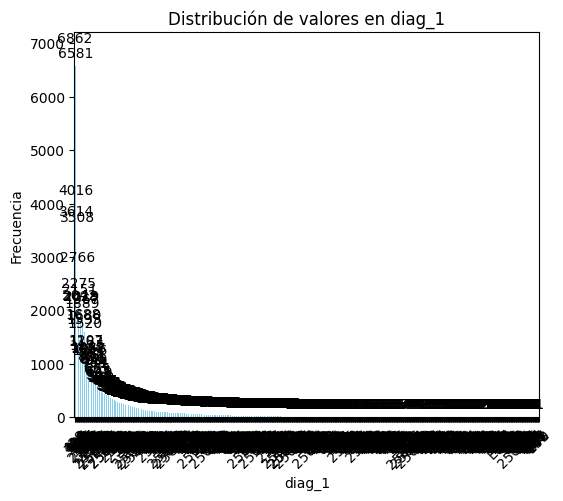

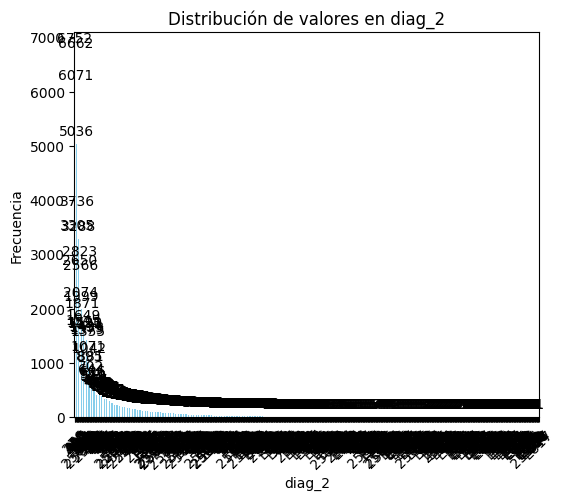

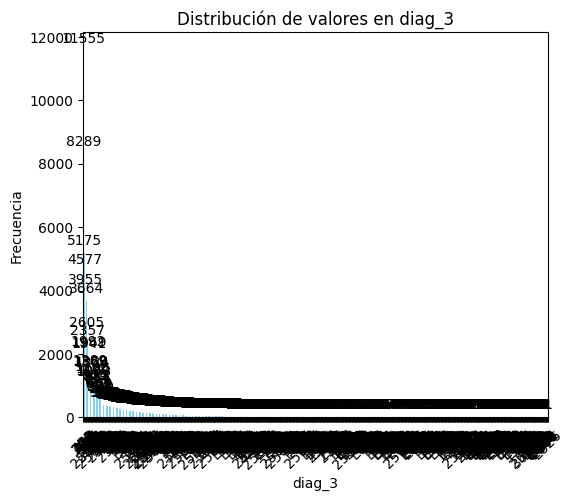

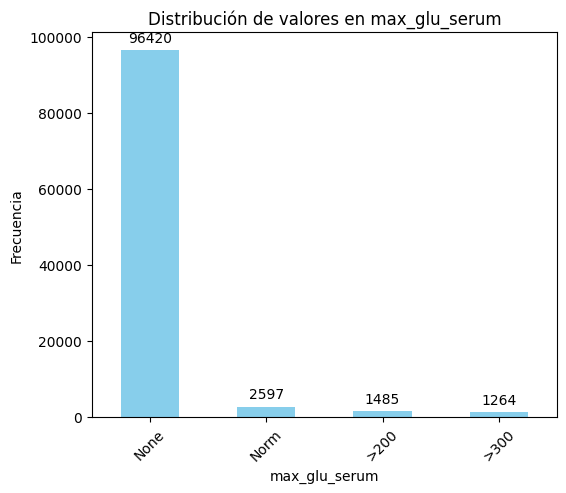

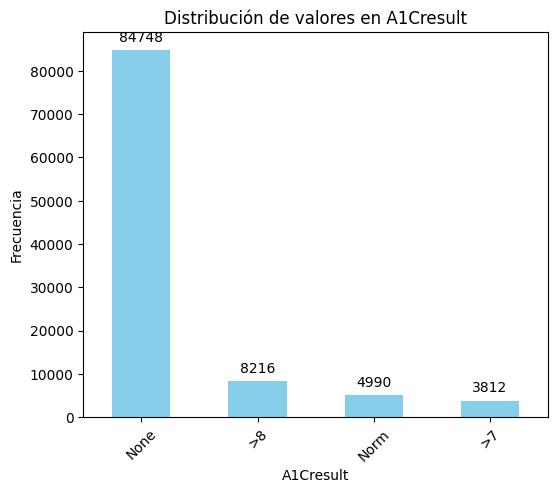

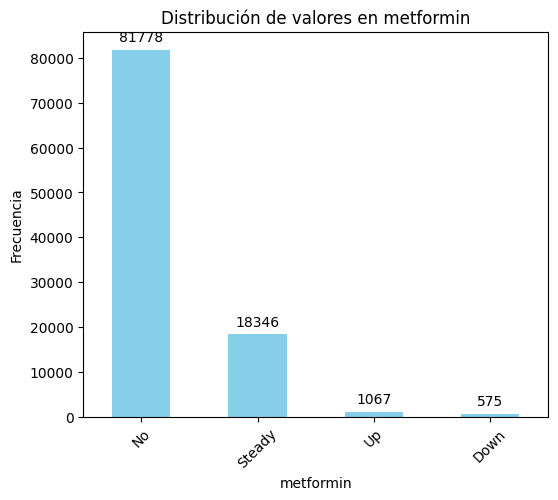

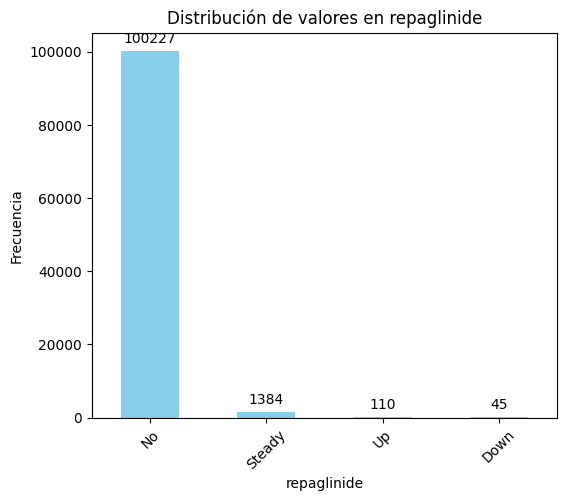

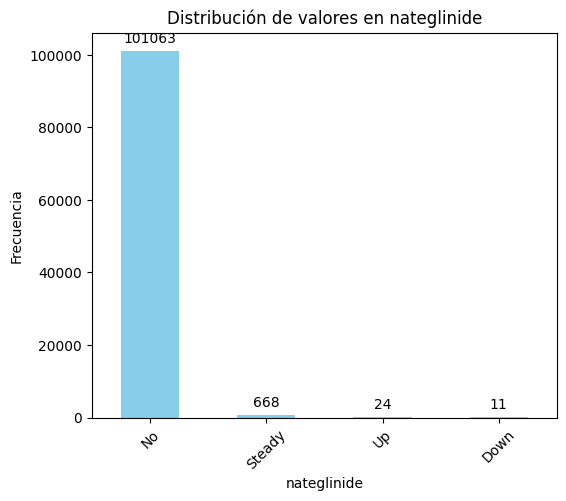

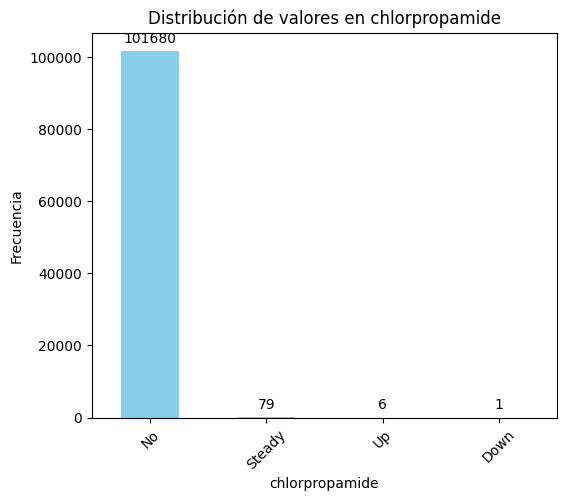

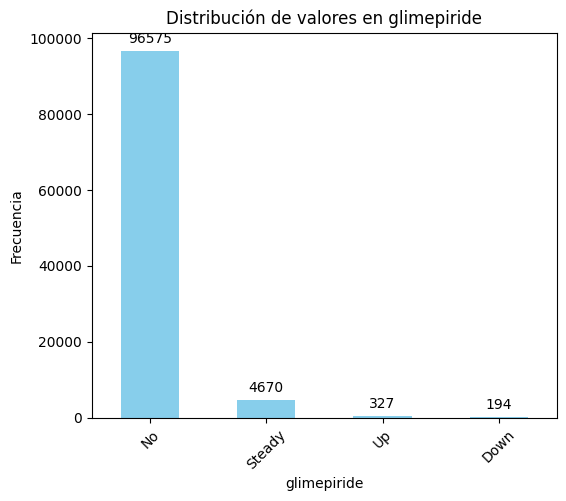

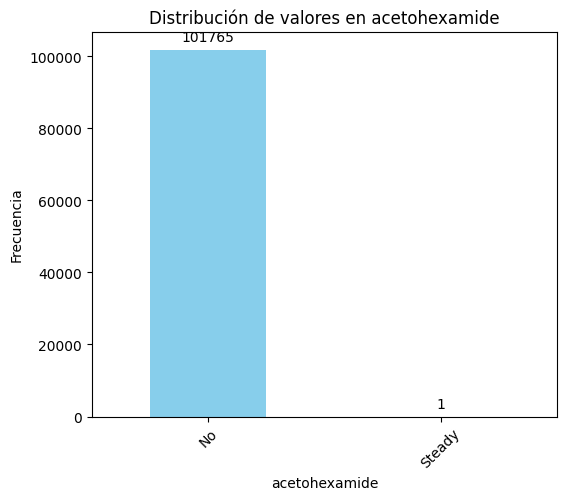

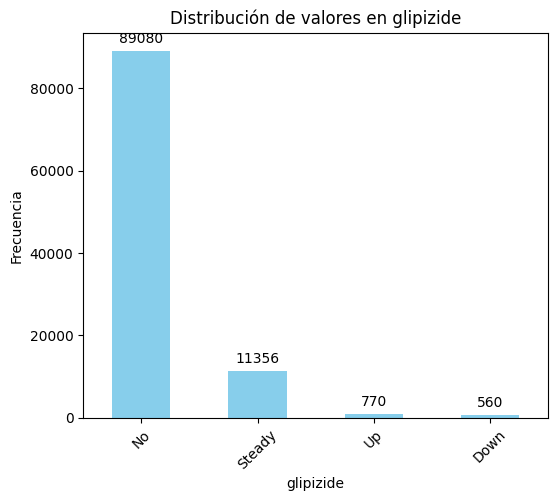

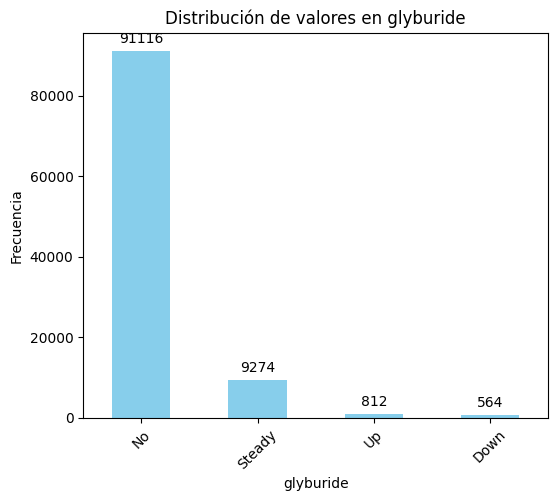

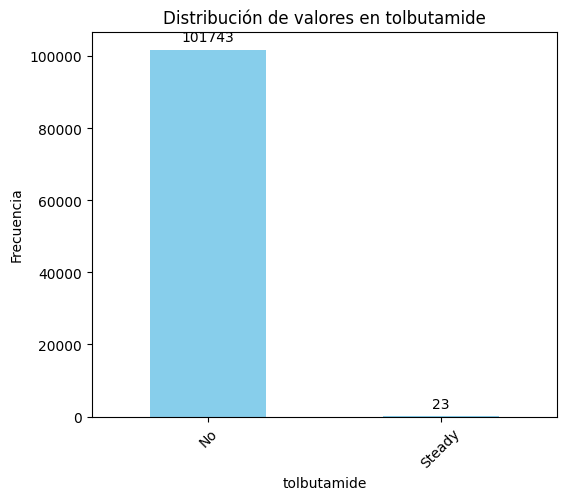

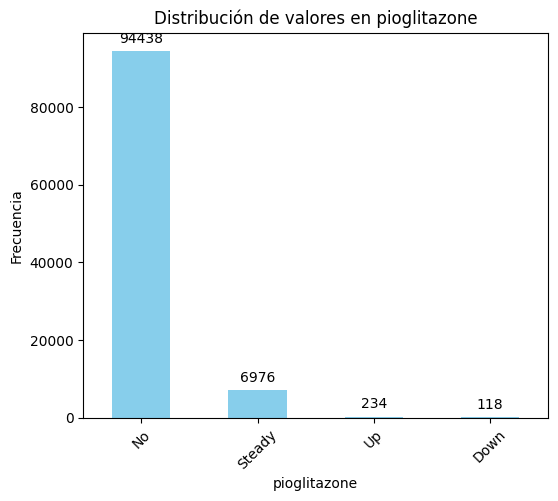

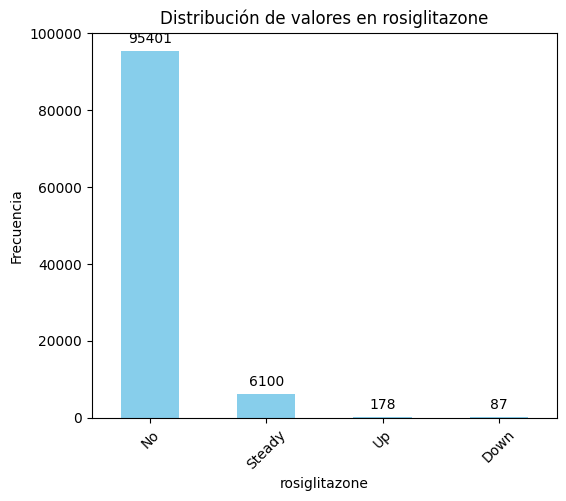

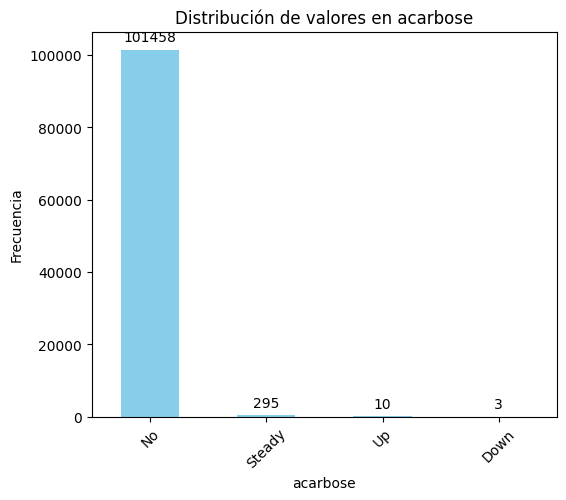

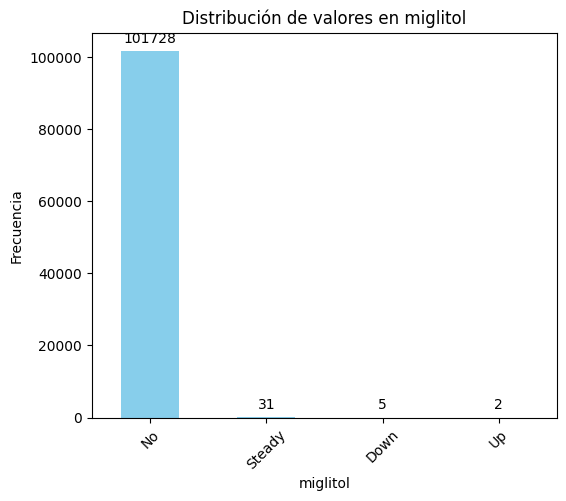

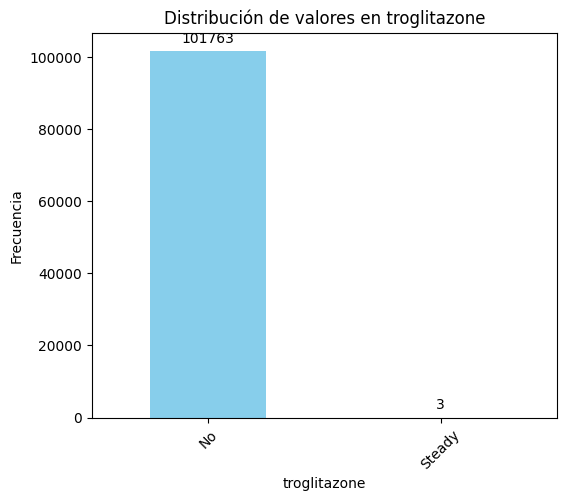

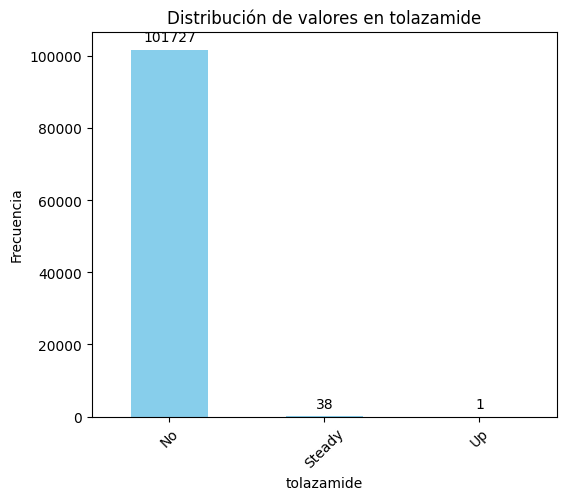

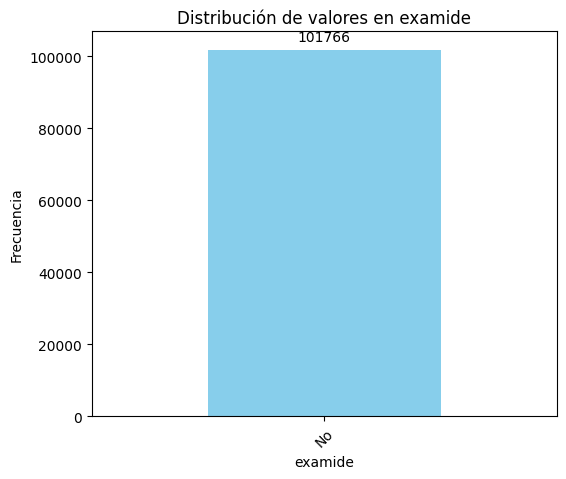

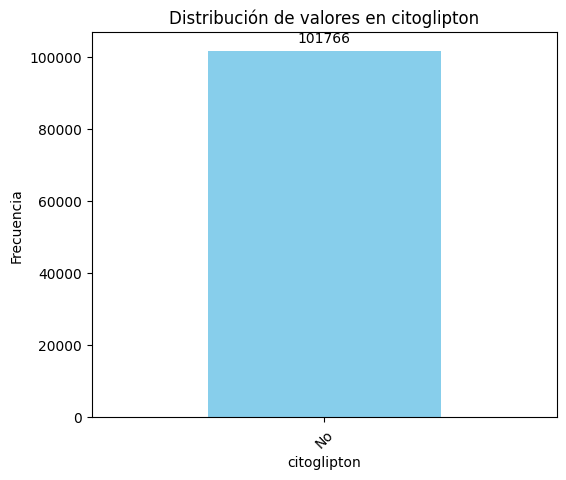

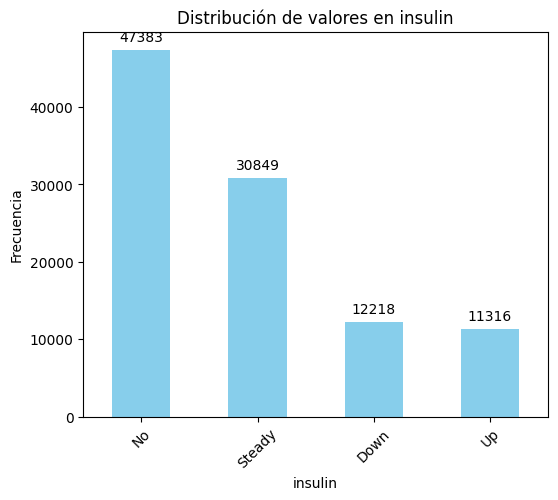

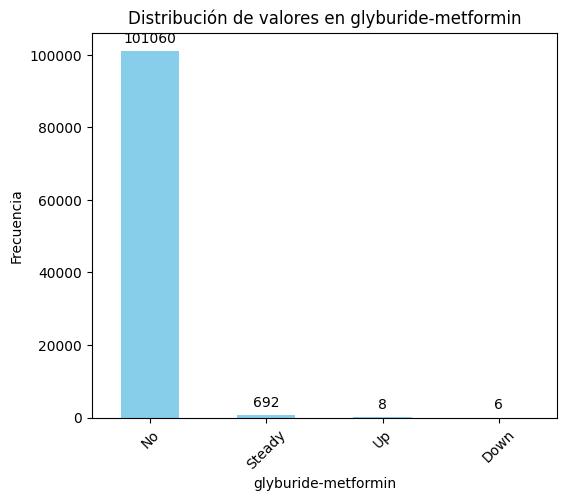

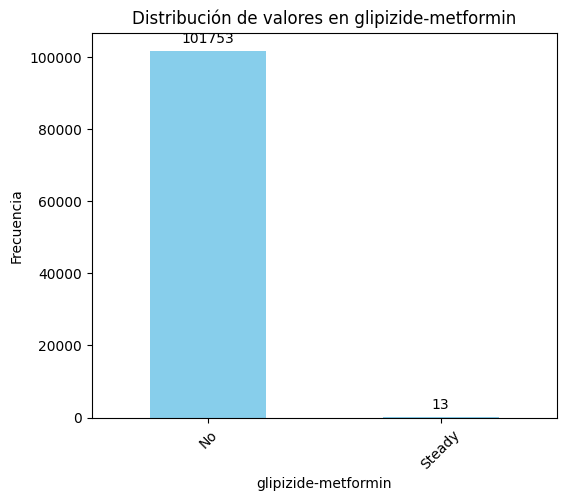

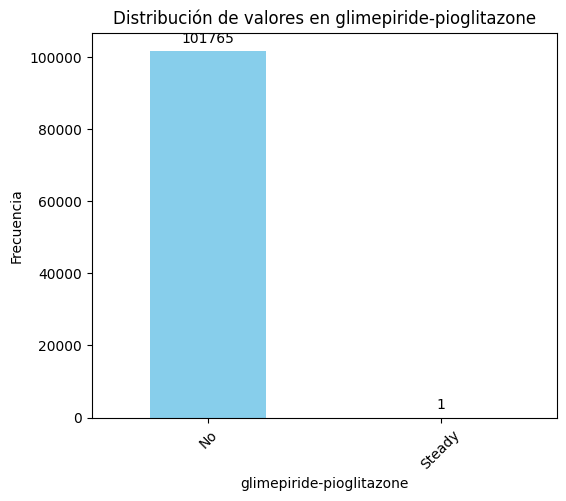

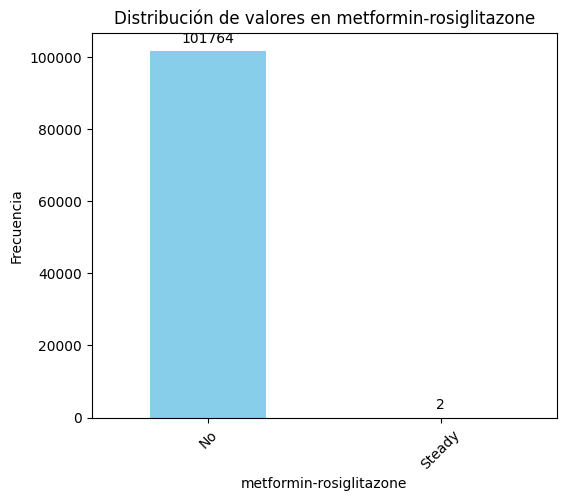

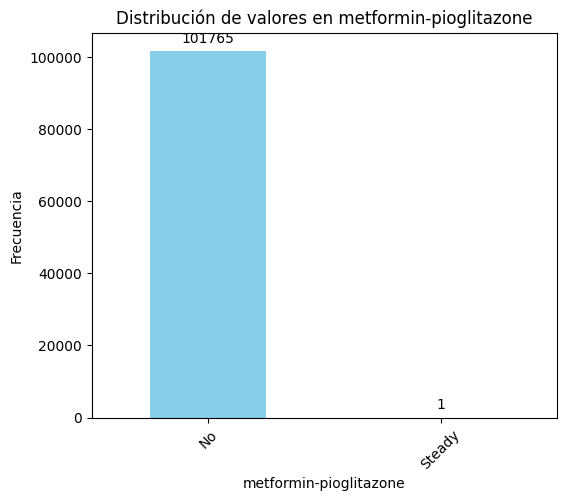

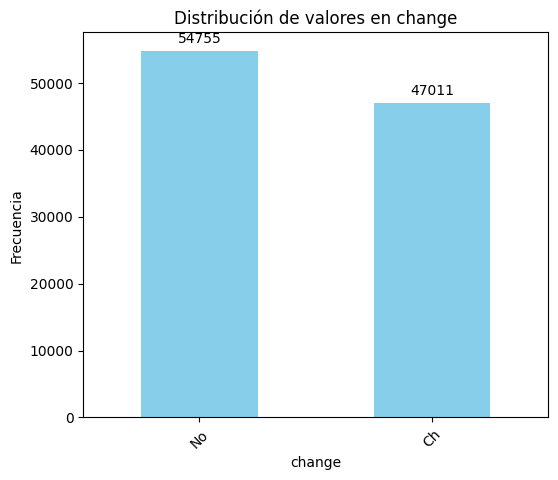

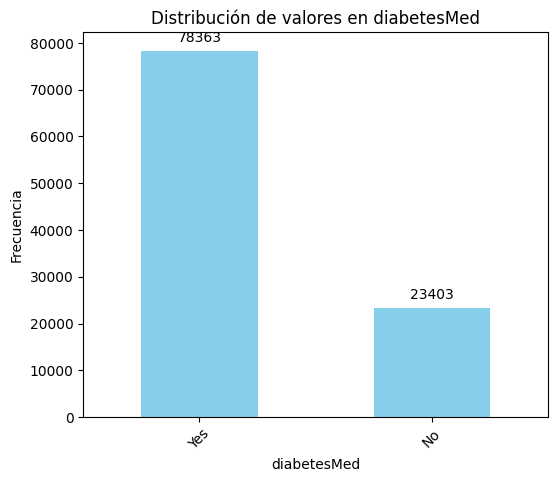

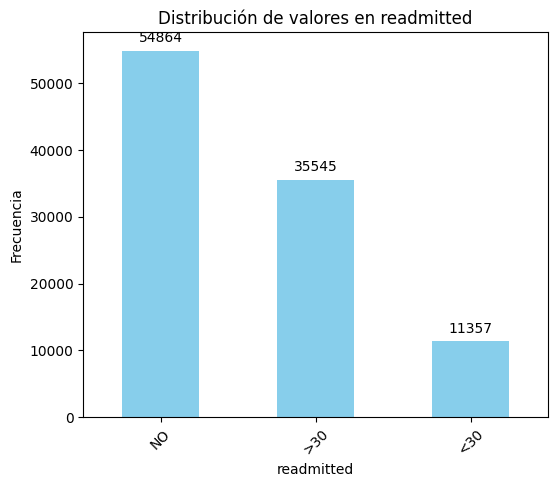

In [154]:
# Graficar la distribución de cada variable cualitativa
for col in variables_cualitativas.columns:
    plt.figure(figsize=(6, 5))
    ax = variables_cualitativas[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribución de valores en {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    
# Mostrar la frecuencia en la parte superior de cada barra
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 9),
                    textcoords='offset points')

    plt.show()

In [155]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [156]:
# Seleccionar solo variables cuantitativas (int64)
variables_cuantitativas = df.select_dtypes(include=['int64'])
variables_cuantitativas.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


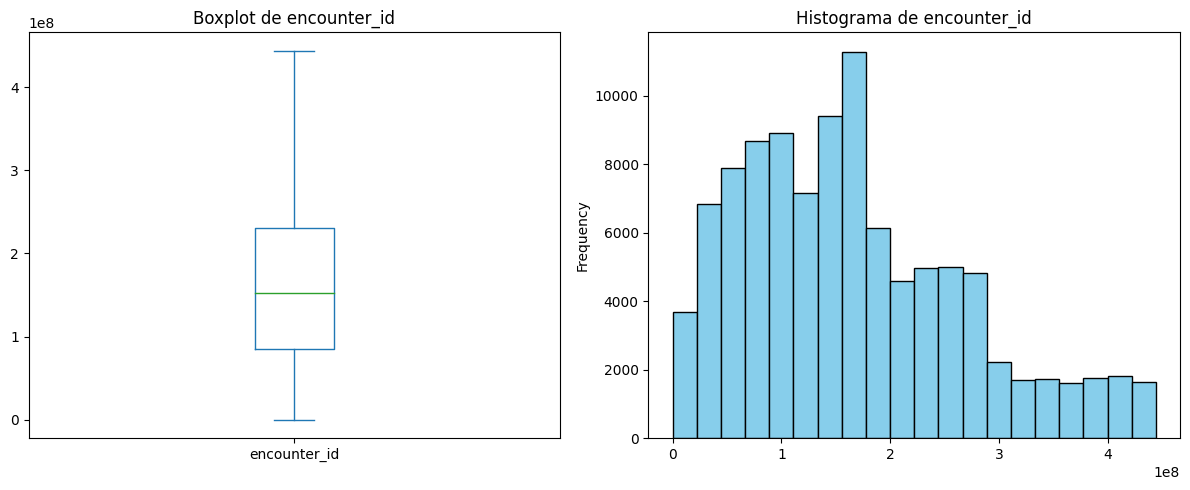

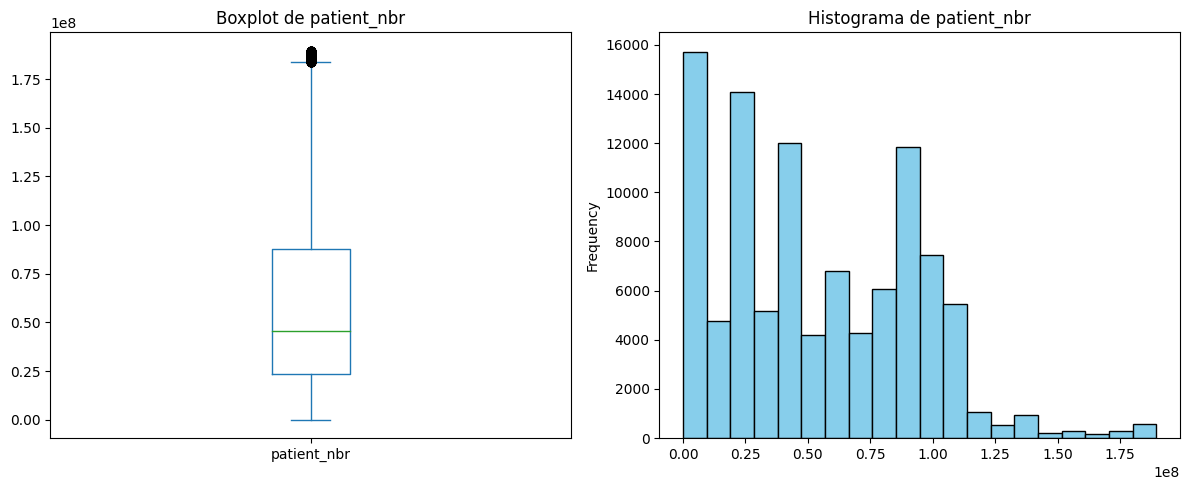

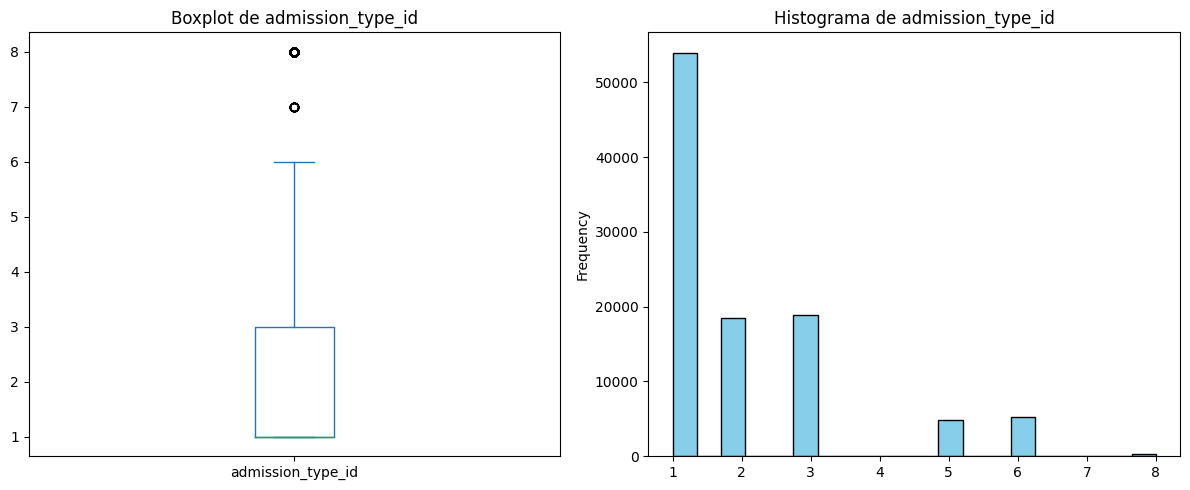

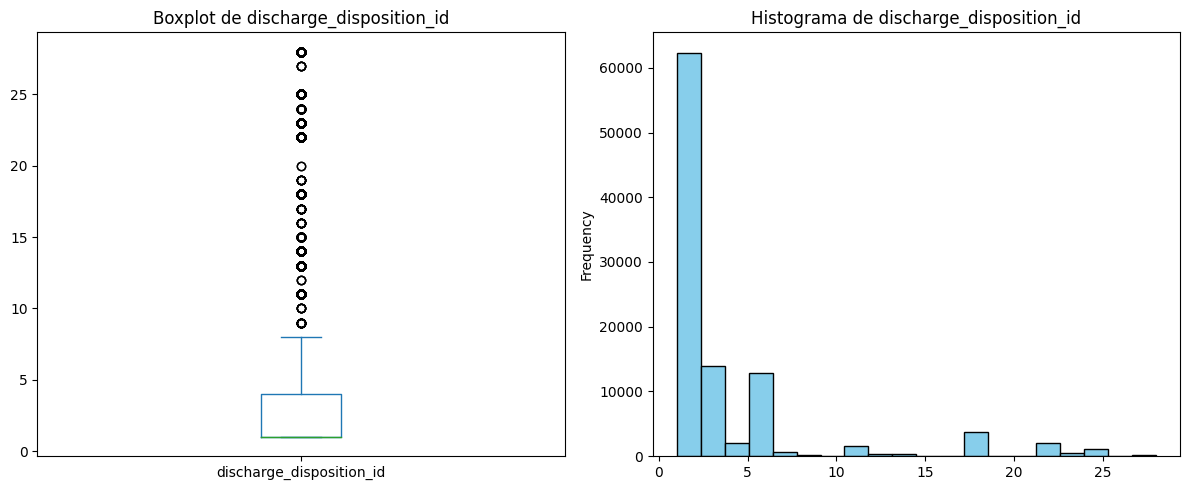

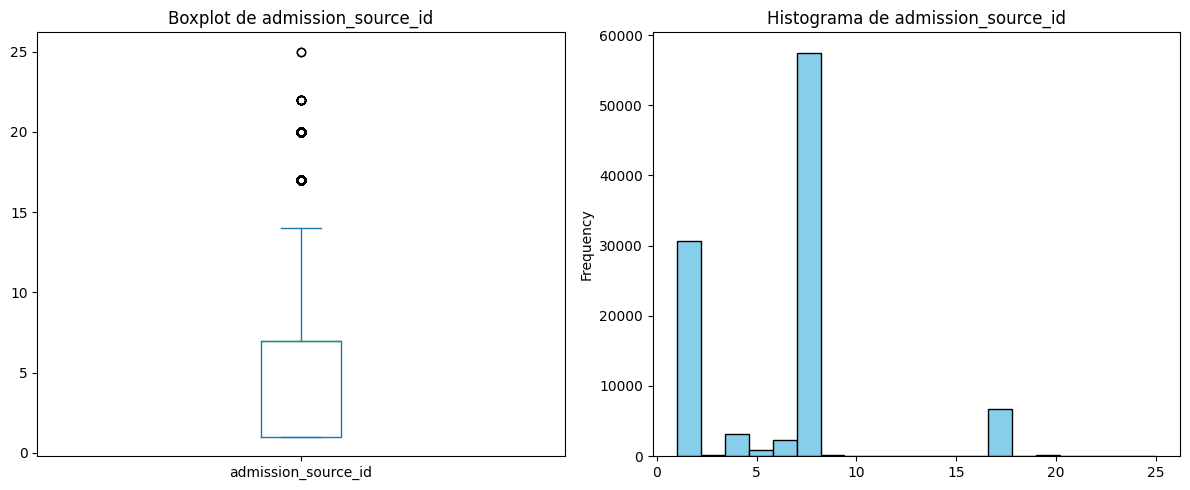

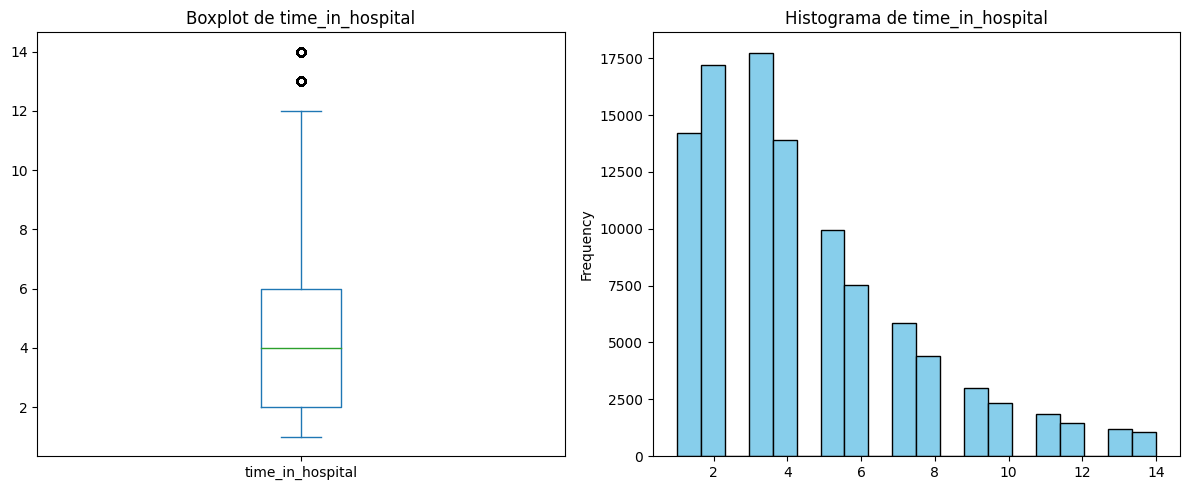

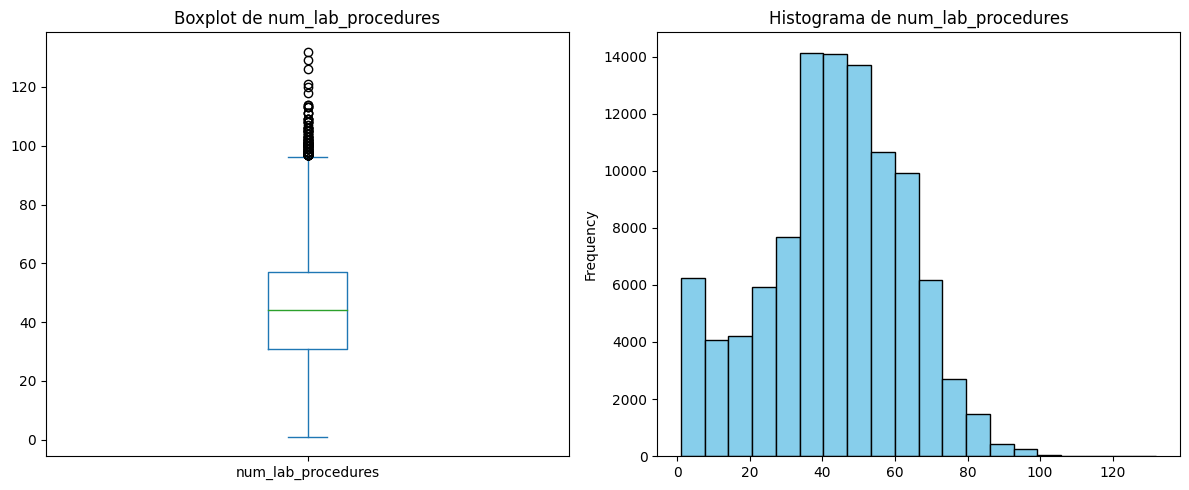

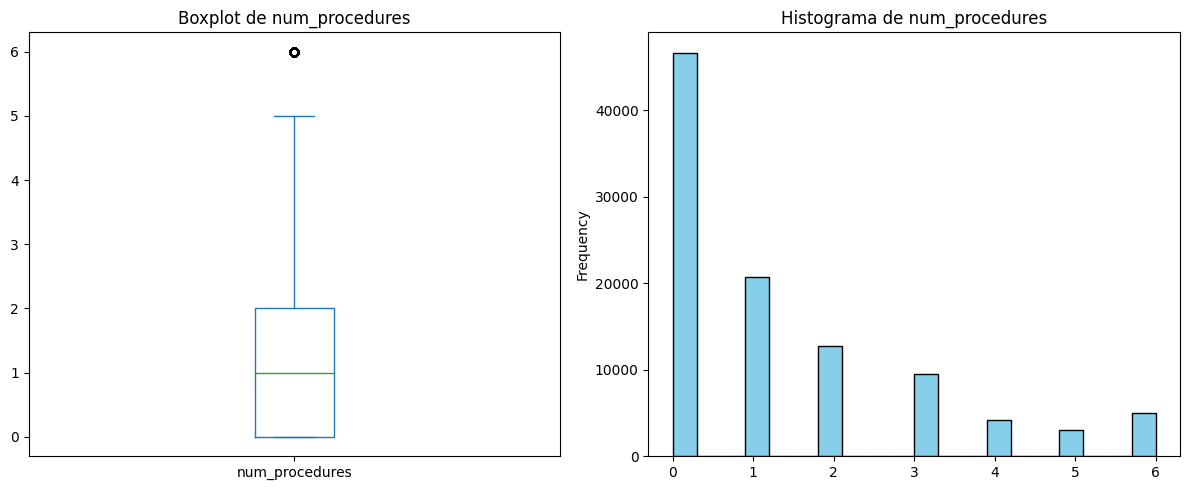

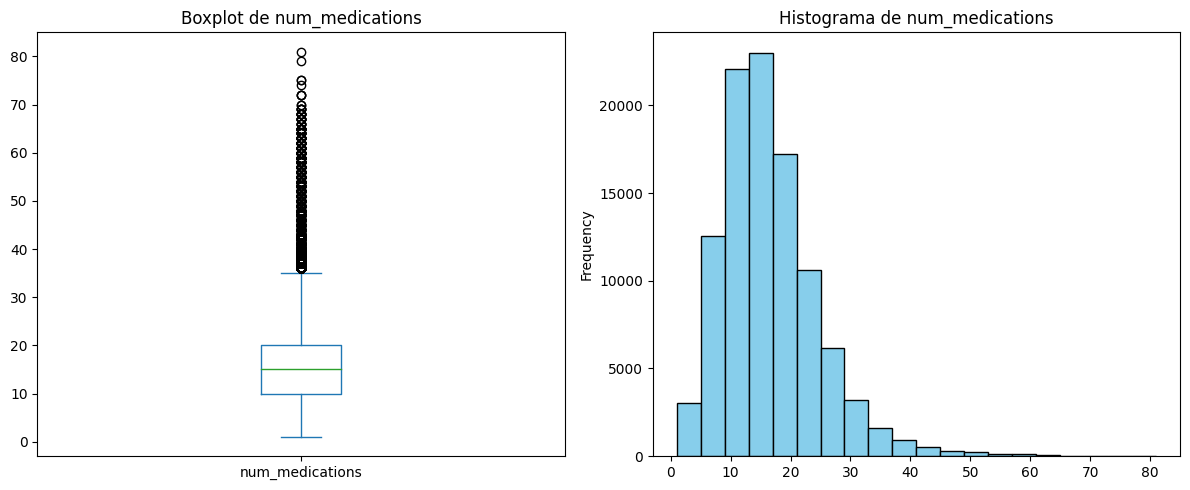

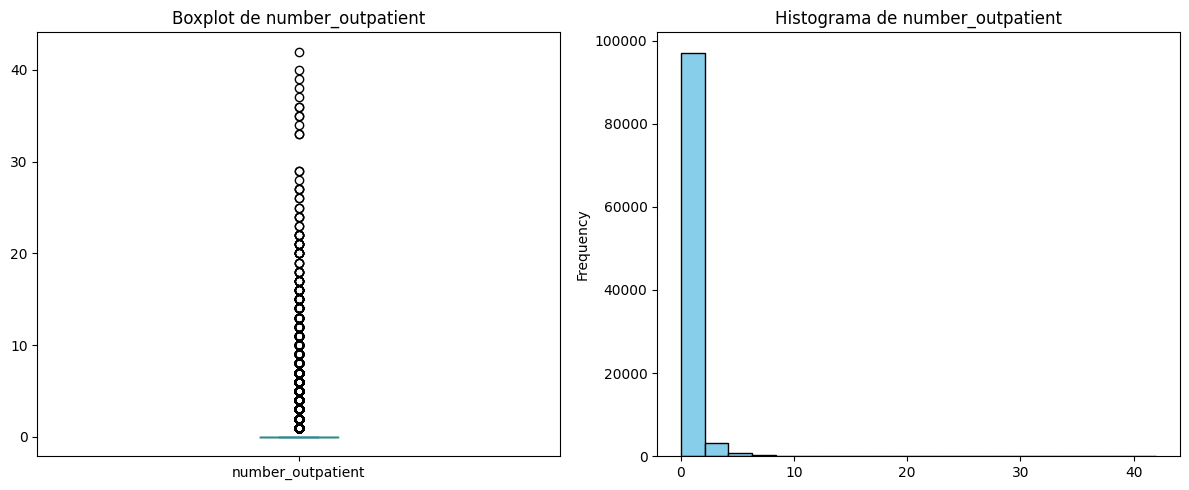

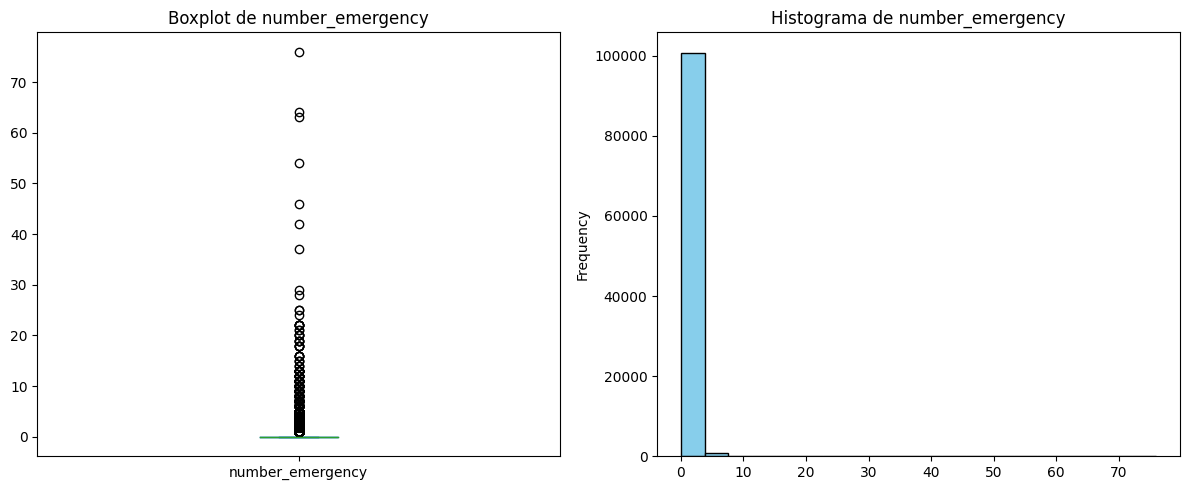

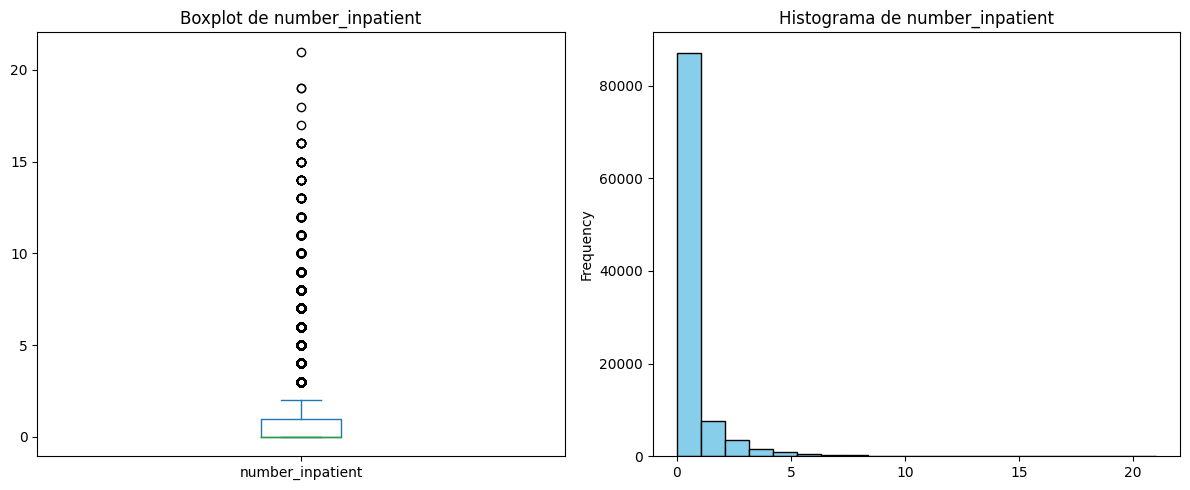

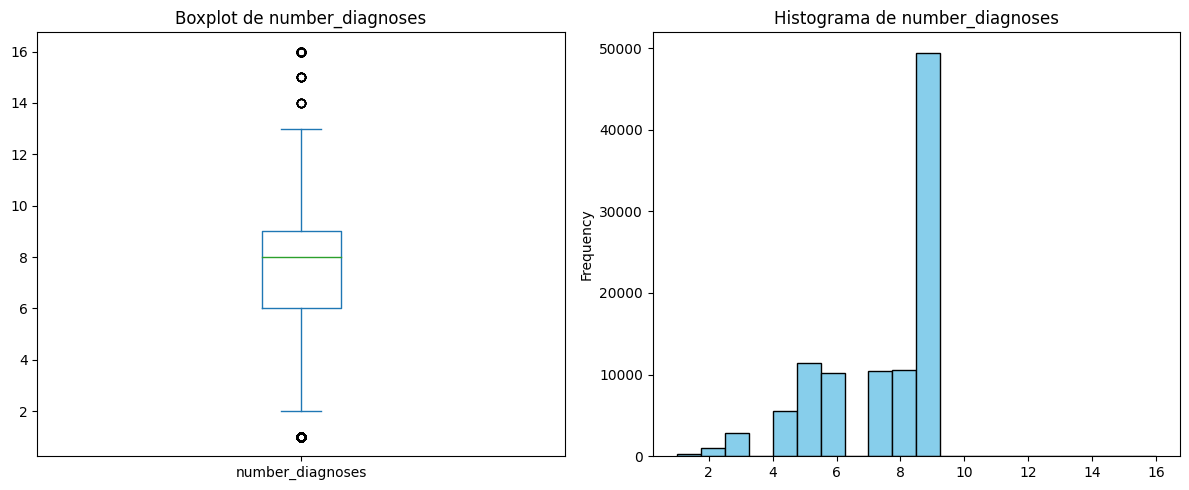

In [10]:
# Generar un boxplot y un histograma para cada variable cuantitativa
for col in variables_cuantitativas.columns:
    # Crear una figura con dos subgráficos (uno para el boxplot y otro para el histograma)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Boxplot
    variables_cuantitativas[col].plot(kind='box', ax=axes[0])
    axes[0].set_title(f'Boxplot de {col}')
    
    # Histograma
    variables_cuantitativas[col].plot(kind='hist', bins=20, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title(f'Histograma de {col}')
    
    plt.tight_layout()
    plt.show()

**2.4 Ingenería de variables** <br>
En esta sección, se llevaron a cabo diversas acciones respaldadas por la revisión preliminar realizada anteriormente:

1. Se procedió a eliminar los registros en los cuales la variable discharge_disposition_id tenía valores 11 y 13, indicando que el paciente había fallecido o había sido remitido a cuidados paliativos.

2. La variable de interés, 'readmitted', fue redefinida como 1 para los casos en que el paciente fue readmitido en menos de 30 días y 0 para aquellos readmitidos después de este período o que no requirieron readmisión. Esto condujo a una transformación de la variable de respuesta en una forma dicotómica, con una representación del 91% para el valor 0 y 8.96% para el valor 1. Se identificó un desbalance de clases, el cual debe ser abordado para evitar sesgos en el modelo hacia la clase mayoritaria.

3. Se procedió a la redefinición de las variables discharge_disposition_id y admission_source_id, que originalmente contenían números enteros que representaban la condición de alta y la fuente de admisión de los pacientes, respectivamente. Estas variables se agruparon para reducir la cantidad de categorías y simplificar su interpretación.

4. Se creó la variable 'total_visits', que representa la utilización global del sistema de atención médica por cada paciente y se calculó como la suma de 'number_outpatient', 'number_emergency' y 'number_inpatient'.

5. Se elimaron las variables 'encounter_id', 'weight', 'payer_code', 'medical_specialty', 'troglitazone', 'tolazamide', 'examide', 'glyburide-metformin', 'admission_type_id', 'number_outpatient', 'number_emergency', 'number_inpatient',     'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'acetohexamide', 'tolbutamide', 'citoglipton', 'glipizide-metformin',         'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' por diversar razón por ejemplo demasiados valores faltantes. poca contribución al modelo y/o algunas variables solo tomaban un valor

In [157]:
# Eliminación de registros cuyo resultado final fue muerte o remitido a cuidados paliativos

data = df[(df['discharge_disposition_id'] != 11) & (df['discharge_disposition_id'] != 13)]
data1 = data.drop_duplicates(subset='patient_nbr', keep='first') ##elimina los registro repetidos por patient_nbr (identificación unica por paciente)
data1.shape

(70211, 50)

In [158]:
# Redefinición de variable objetivo
data1['readmitted'] = data1['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})
data1['readmitted'].value_counts()

C:\Users\Jesús\AppData\Local\Temp\ipykernel_7684\3782315842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['readmitted'] = data1['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})


0    63917
1     6294
Name: readmitted, dtype: int64

In [159]:
redefinicion_discharge = {
    1: 'Alta a Domicilio',
    2: 'Alta a Institución',
    3: 'Alta a Institución',
    4: 'Alta a Institución',
    5: 'Alta a Institución',
    6: 'Alta a Institución',
    7: 'Otras Situaciones de Alta',
    8: 'Alta a Institución',
    9: 'Alta a Institución',
    10: 'Alta a Institución',
    11: 'Otras Situaciones de Alta',
    12: 'Alta a Institución',
    13: 'Otras Situaciones de Alta',
    14: 'Alta a Institución',
    15: 'Alta a Institución',
    16: 'Alta a Institución',
    17: 'Alta a Institución',
    18: 'Alta a Institución',
    19: 'Alta a Institución',
    20: 'Alta a Institución',
    21: 'Alta a Institución',
    22: 'Alta a Institución',
    23: 'Alta a Institución',
    24: 'Alta a Institución',
    25: 'Alta a Institución',
    26: 'Alta a Institución',
    27: 'Alta a Institución',
    28: 'Alta a Institución'
}

# Redefinir la variable "discharge_disposition_id"
data1['discharge_disposition_id'] = data1['discharge_disposition_id'].replace(redefinicion_discharge)


# Mostrar la base de datos con la variable redefinida
data1['discharge_disposition_id'].value_counts()

C:\Users\Jesús\AppData\Local\Temp\ipykernel_7684\4268374444.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['discharge_disposition_id'] = data1['discharge_disposition_id'].replace(redefinicion_discharge)


Alta a Domicilio             44322
Alta a Institución           25480
Otras Situaciones de Alta      409
Name: discharge_disposition_id, dtype: int64

In [160]:
redefinicion_admission = {
    1: 'Consulta Externa',
    2: 'Consulta Externa',
    3: 'Otras Fuentes',
    4: 'Otras Fuentes',
    5: 'Transferencia',
    6: 'Transferencia',
    7: 'Otras Fuentes',
    8: 'Otras Fuentes',
    9: 'Otras Fuentes',
    10: 'Consulta Externa',
    11: 'Consulta Externa',
    12: 'Consulta Externa',
    13: 'Consulta Externa',
    14: 'Consulta Externa',
    15: 'Consulta Externa',
    17: 'Consulta Externa',
    20: 'Consulta Externa',
    21: 'Consulta Externa',
    22: 'Consulta Externa',
    23: 'Consulta Externa',
    24: 'Consulta Externa',
    25: 'Consulta Externa',
    26: 'Consulta Externa',
    27: 'Transferencia',
    30: 'Consulta Externa'
}

# Redefinir la variable "admission_source_id"
data1['admission_source_id'] = data1['admission_source_id'].replace(redefinicion_admission)

data1["admission_source_id"].value_counts()

C:\Users\Jesús\AppData\Local\Temp\ipykernel_7684\334971918.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['admission_source_id'] = data1['admission_source_id'].replace(redefinicion_admission)


Otras Fuentes       40189
Consulta Externa    27723
Transferencia        2299
Name: admission_source_id, dtype: int64

In [161]:
# Sumar las tres variables y crear una nueva columna "total_visits"
data1['total_visits'] = data1['number_outpatient'] + data1['number_emergency'] + data1['number_inpatient']

C:\Users\Jesús\AppData\Local\Temp\ipykernel_7684\2010320952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['total_visits'] = data1['number_outpatient'] + data1['number_emergency'] + data1['number_inpatient']


In [162]:
# Lista de variables a eliminar
variables_a_eliminar = ['encounter_id', 'weight', 'payer_code', 'medical_specialty', 'troglitazone', 'tolazamide', 'examide',
                       'glyburide-metformin', 'admission_type_id', 'number_outpatient', 'number_emergency', 'number_inpatient',
                       'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'acetohexamide', 'tolbutamide', 'citoglipton', 'glipizide-metformin', 
                        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

# Eliminar las variables especificadas
data1 = data1.drop(variables_a_eliminar, axis=1)


In [163]:
data1.columns

Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'total_visits'],
      dtype='object')

In [164]:
# Lista de variables a considerar
variables_medicamentos = ['metformin', 'repaglinide', 'nateglinide',
                           'chlorpropamide', 'glimepiride', 'glipizide',
                           'glyburide', 'pioglitazone', 'rosiglitazone',
                           'acarbose', 'miglitol', 'insulin']

# Crear una nueva columna para cada medicamento indicando si hubo cambio en la dosis
for variable in variables_medicamentos:
    data1[f'{variable}_dosage_change'] = data1[variable].apply(lambda x: "Si" if x in ['Up', 'Down'] else "No")

# Verificar los cambios
data1[variables_medicamentos + [f'{variable}_dosage_change' for variable in variables_medicamentos]].head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,...,nateglinide_dosage_change,chlorpropamide_dosage_change,glimepiride_dosage_change,glipizide_dosage_change,glyburide_dosage_change,pioglitazone_dosage_change,rosiglitazone_dosage_change,acarbose_dosage_change,miglitol_dosage_change,insulin_dosage_change
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Si
2,No,No,No,No,No,Steady,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Si
4,No,No,No,No,No,Steady,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [165]:
# Lista de variables a eliminar
variables_a_eliminar = ['metformin', 'repaglinide', 'nateglinide',
                           'chlorpropamide', 'glimepiride', 'glipizide',
                           'glyburide', 'pioglitazone', 'rosiglitazone',
                           'acarbose', 'miglitol', 'insulin']

# Eliminar las variables especificadas
data1 = data1.drop(variables_a_eliminar, axis=1)

**2.5 Selección de variables relevantes** <br> 

En esta sección se procedio a realizar un análisis bivarido entre las variables vs la variable de respuesta para ver el comportamiento de las personas que fueron readmitidas. se utilizo diagrama de barras comparativas para las variables cualitativas y matriz de correlación para la variables cuantitativas e histogramas para observar la distribución de las variables con respecto a la variable de respuesta.

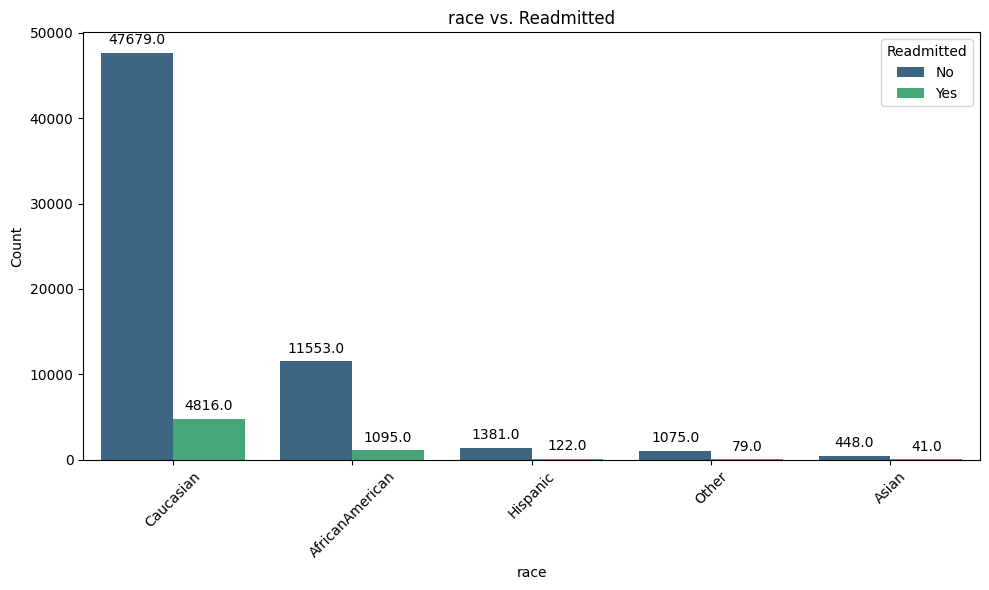

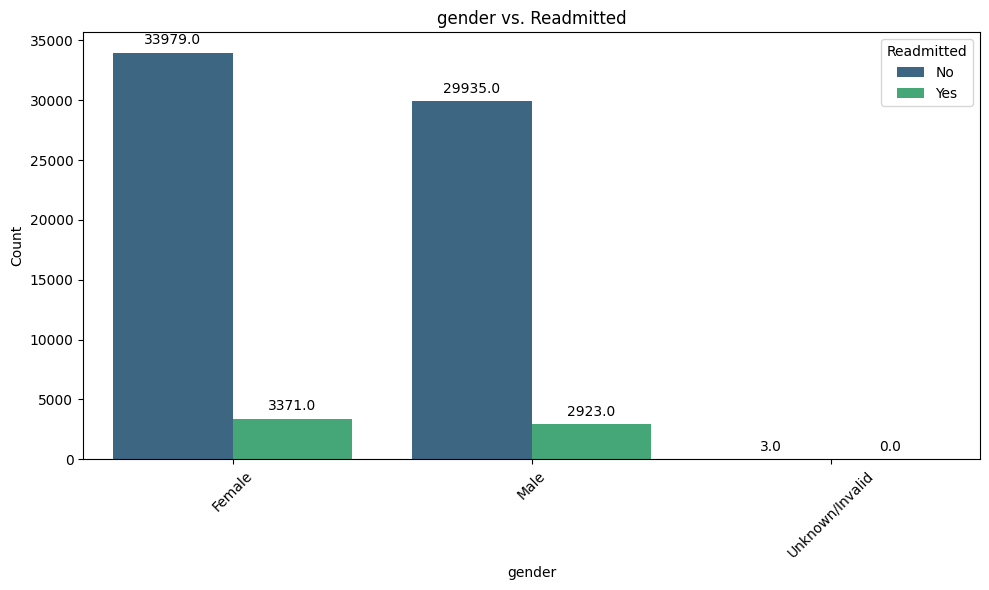

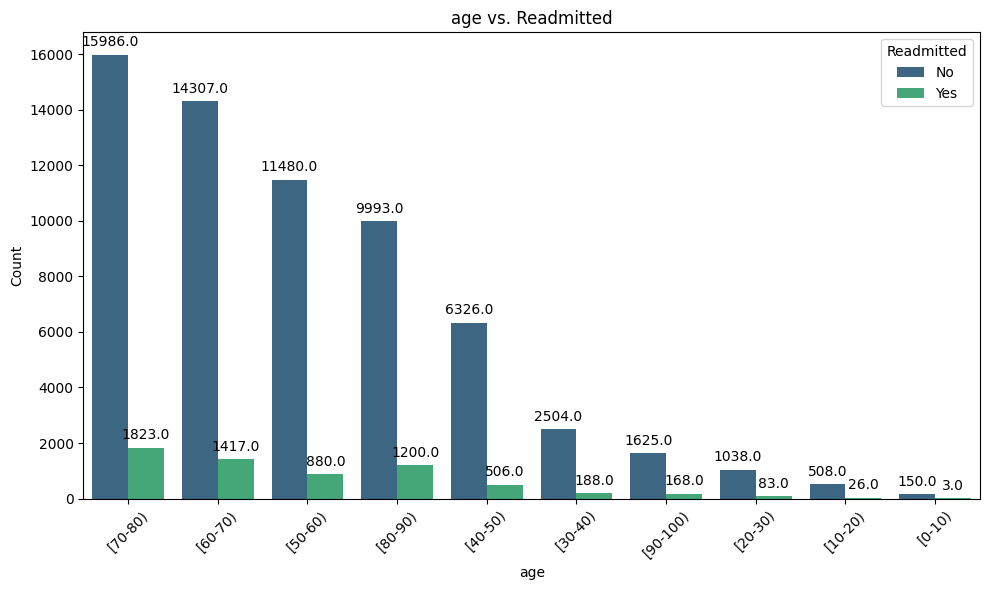

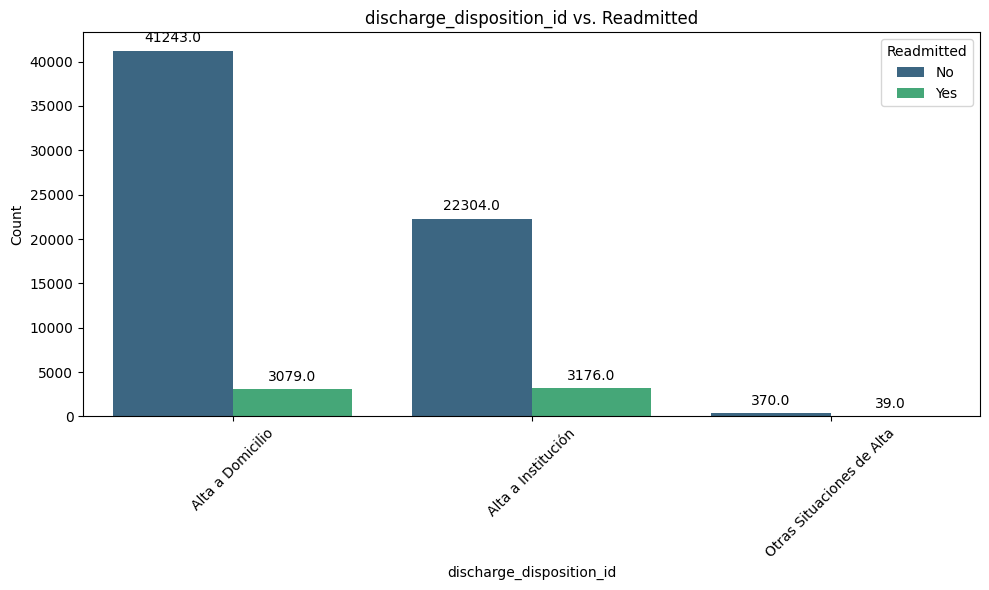

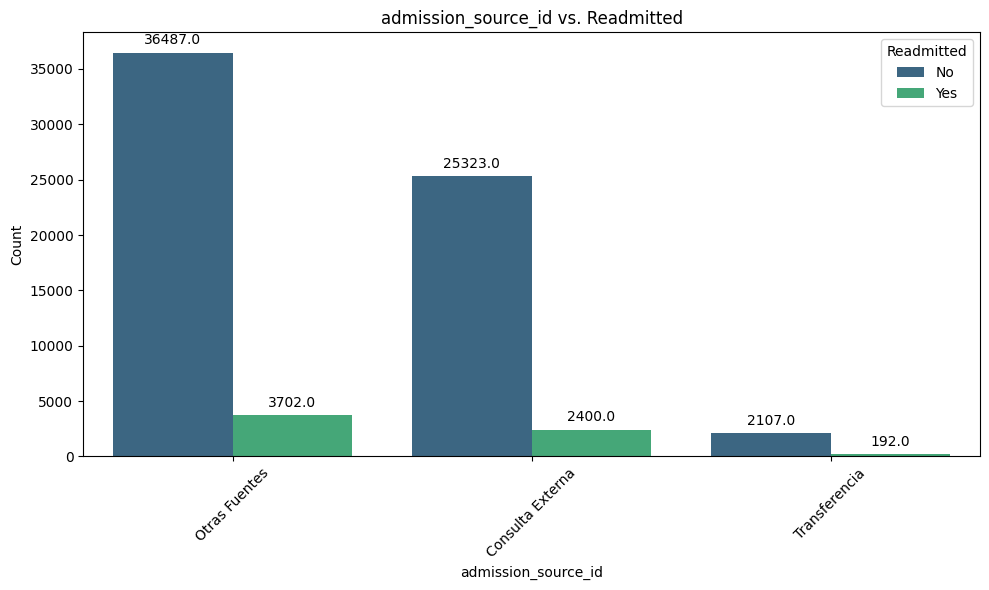

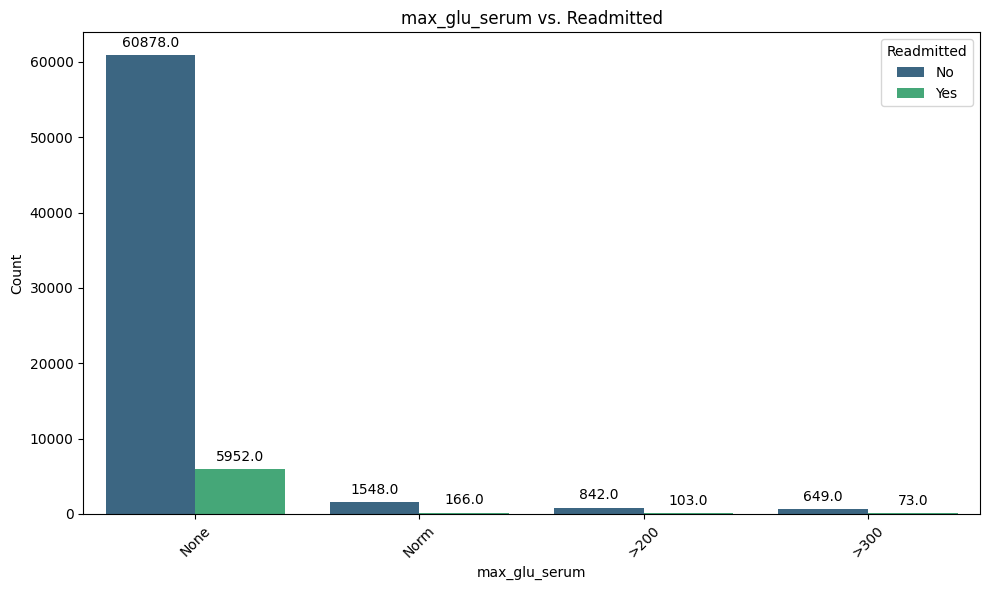

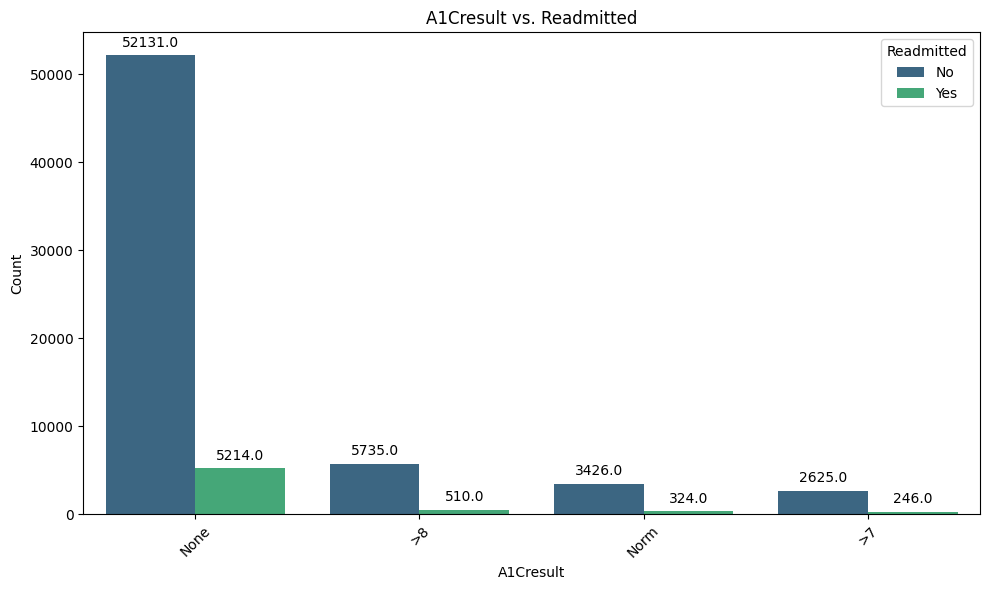

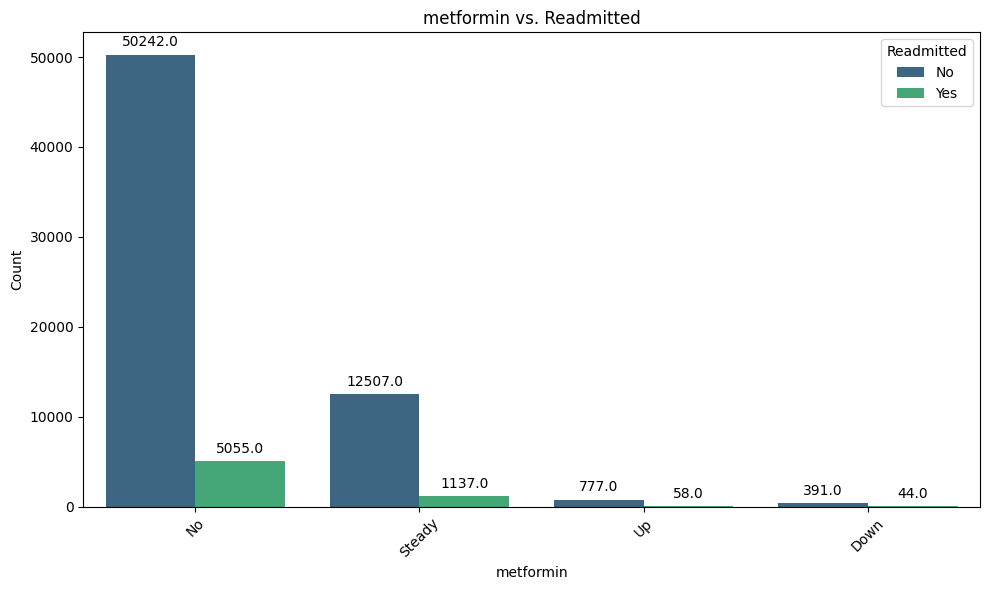

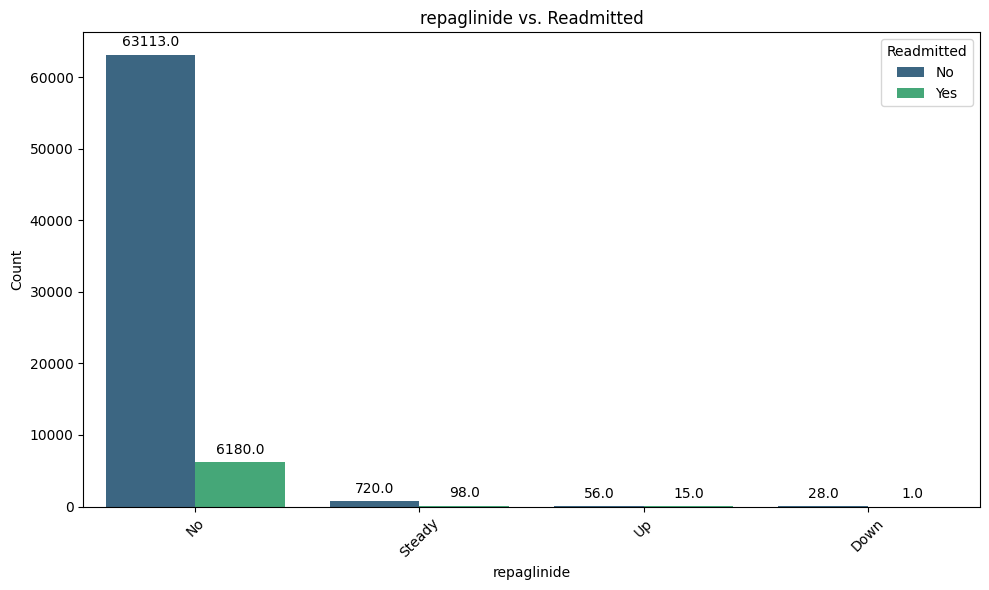

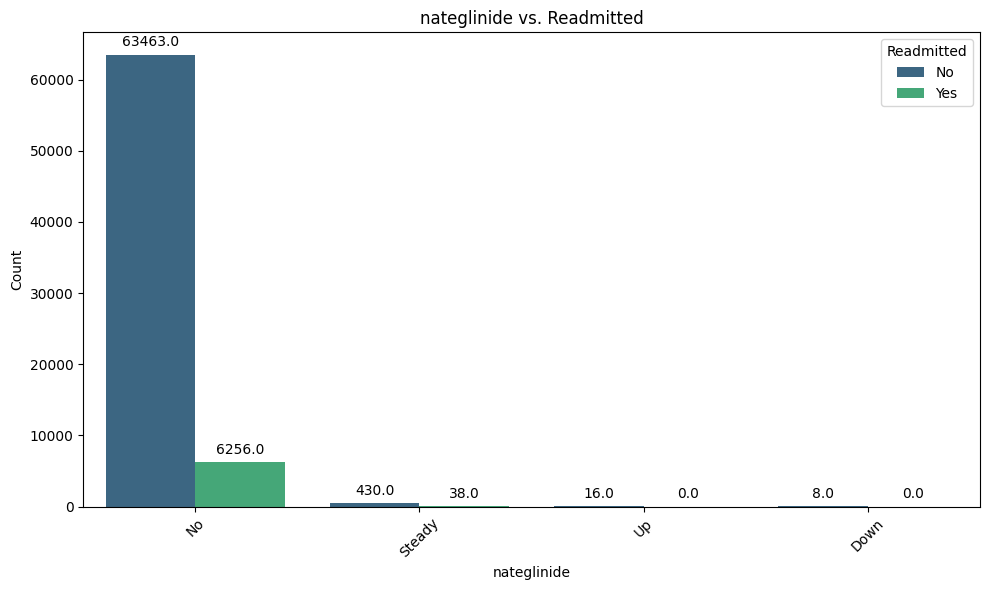

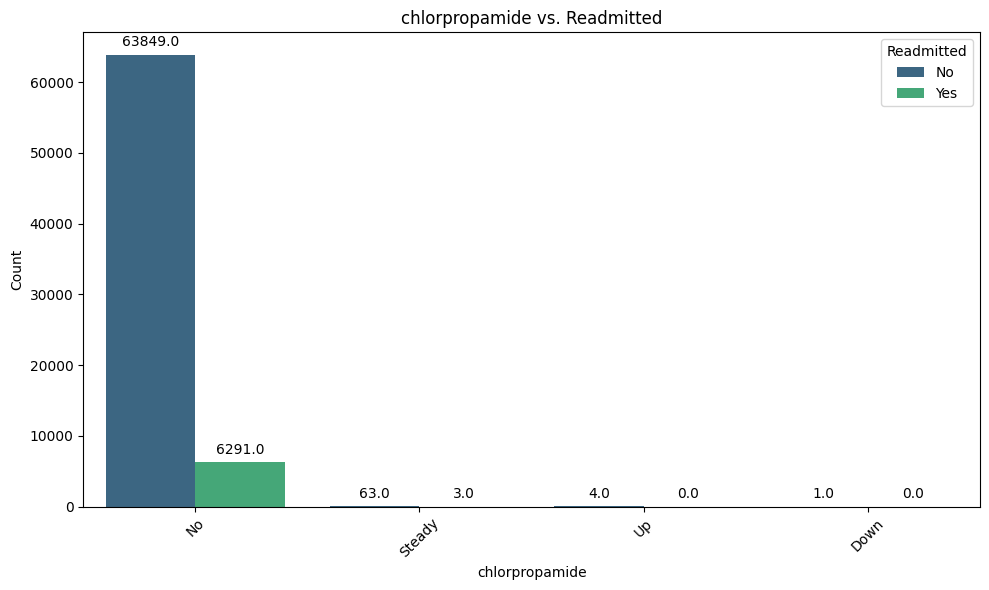

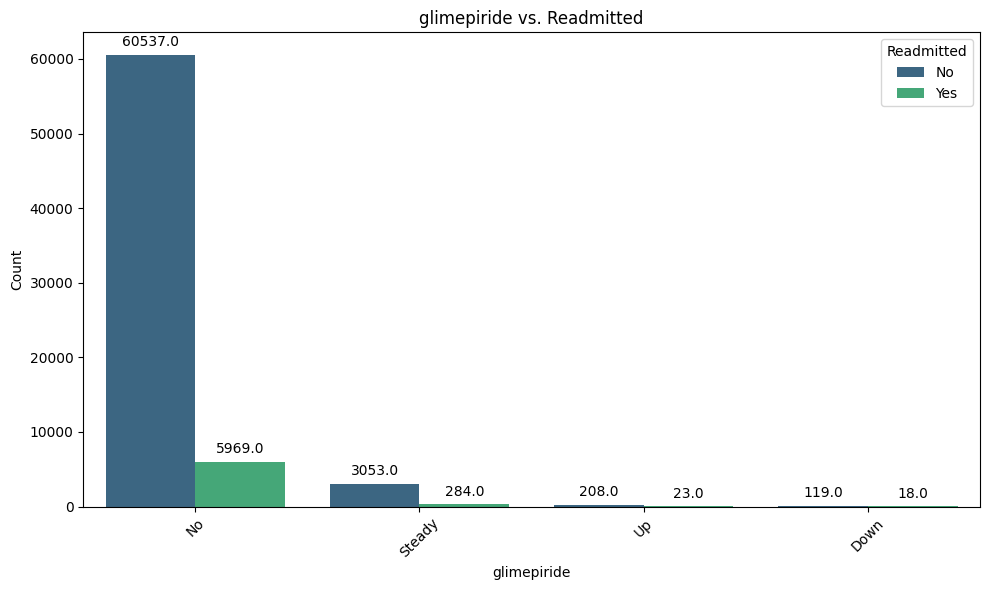

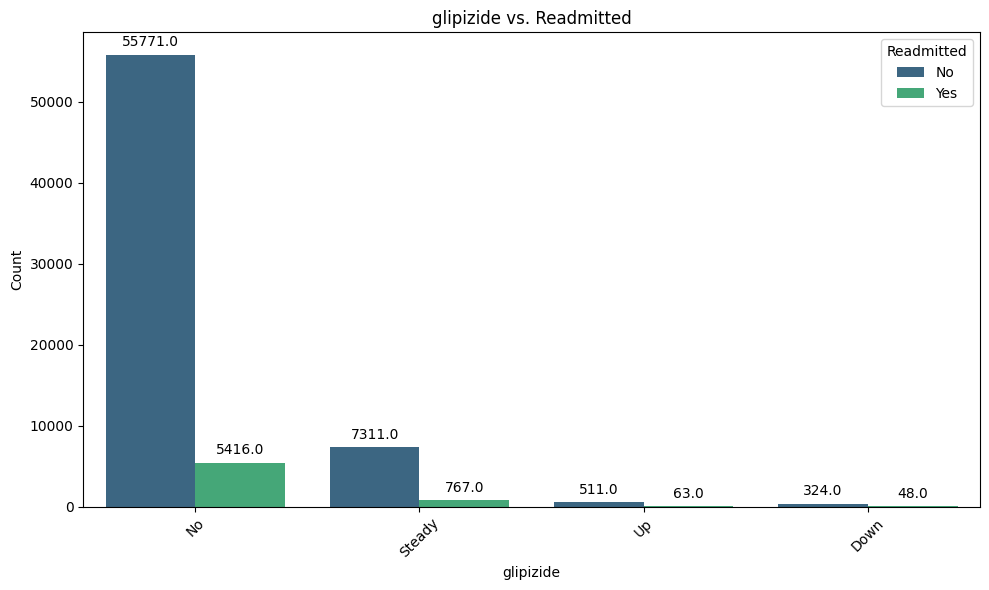

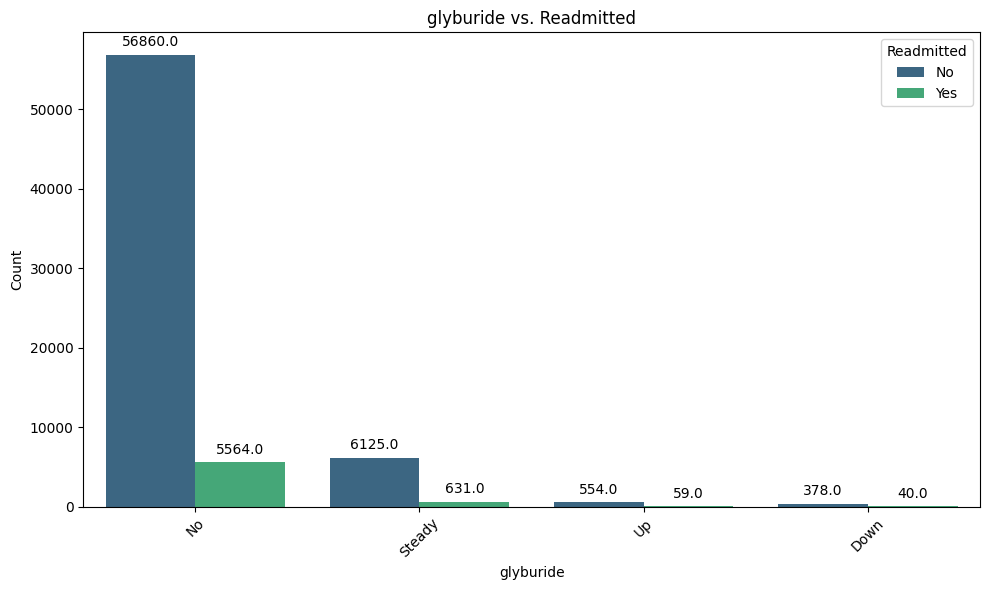

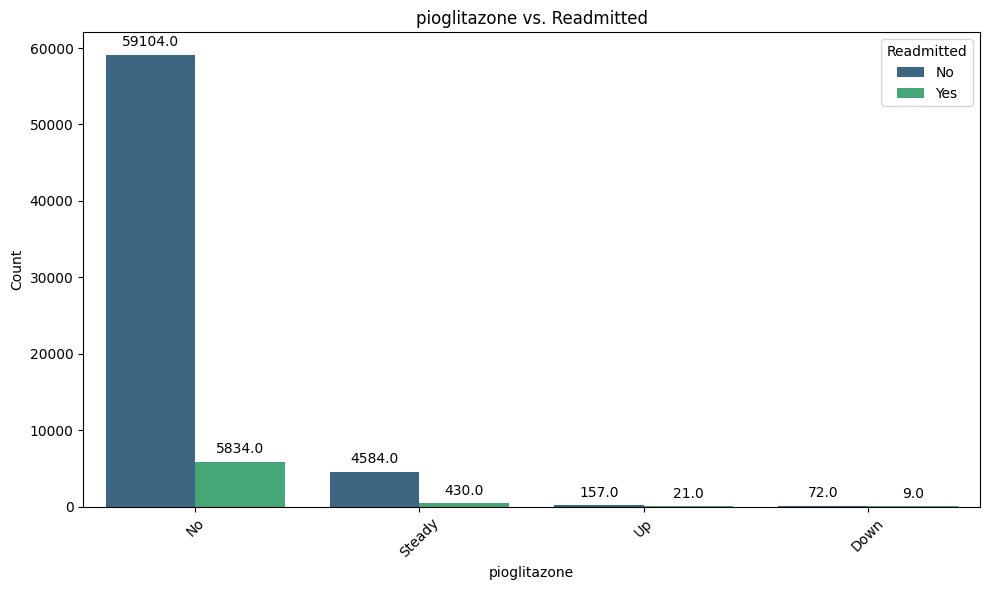

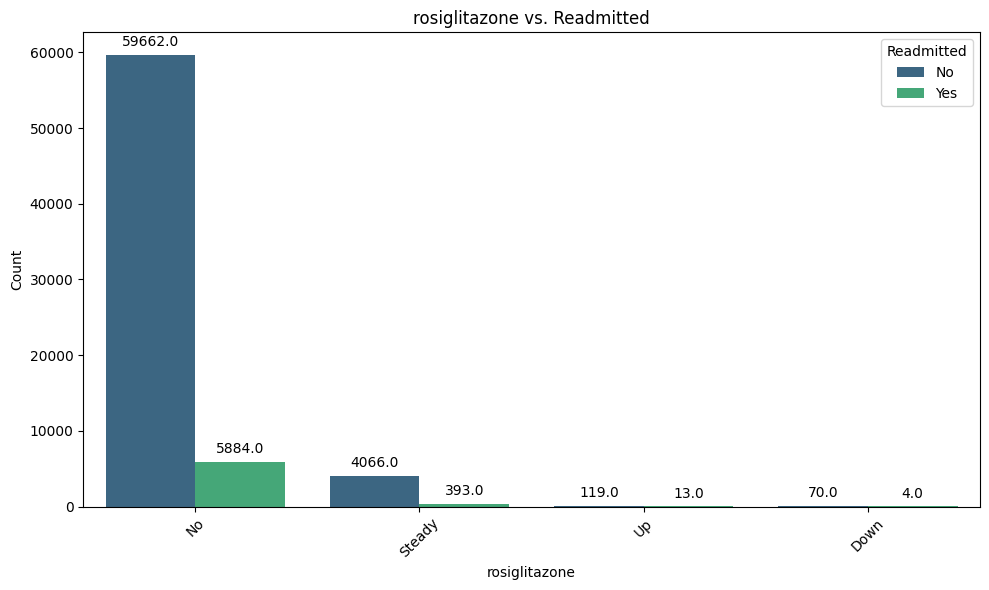

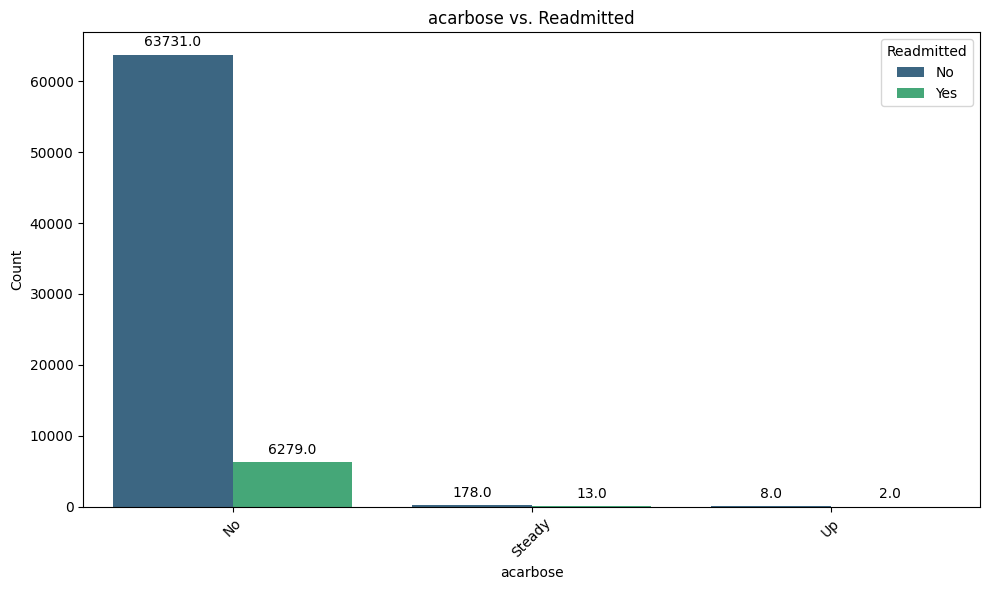

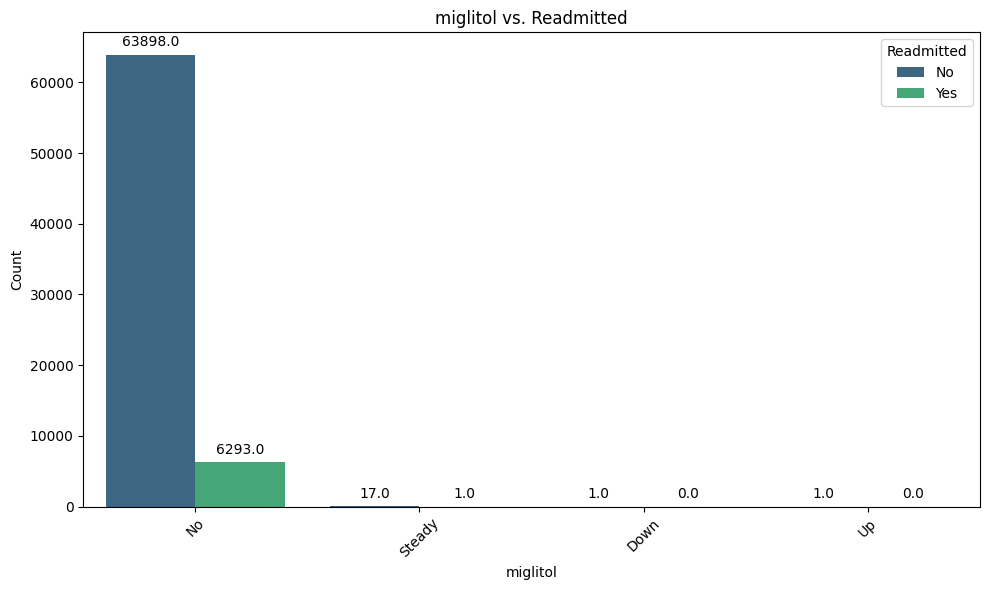

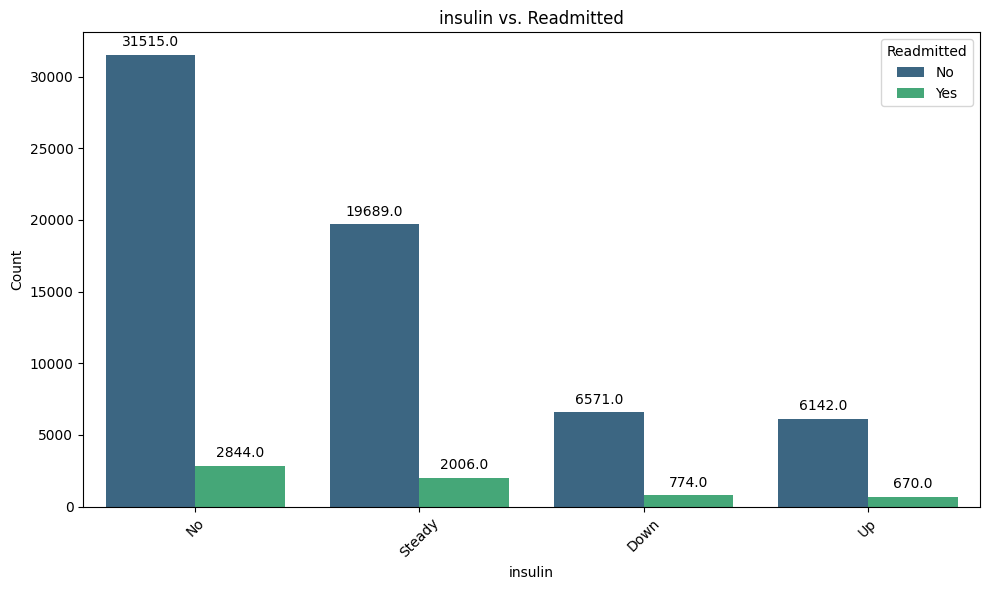

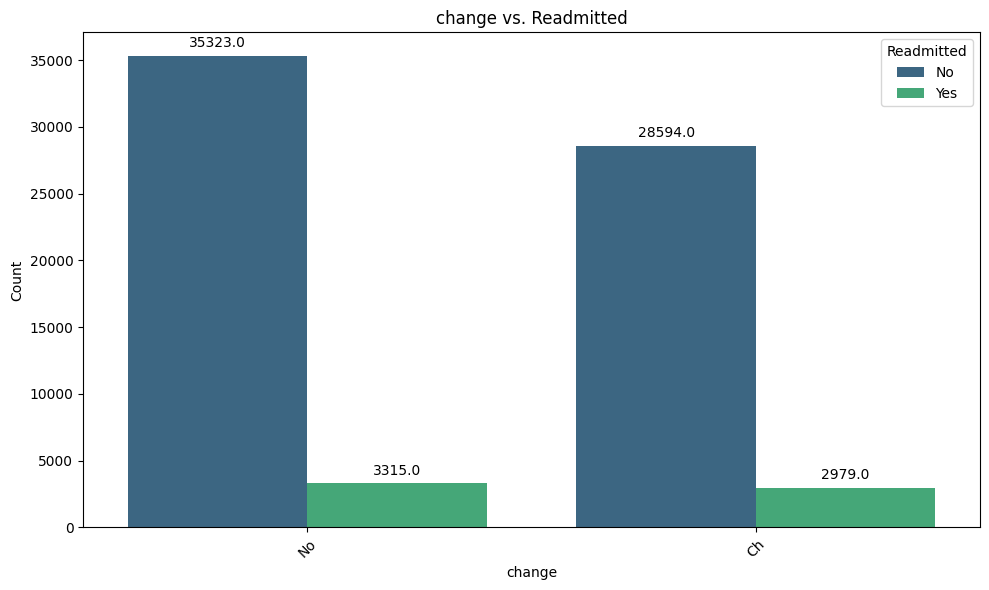

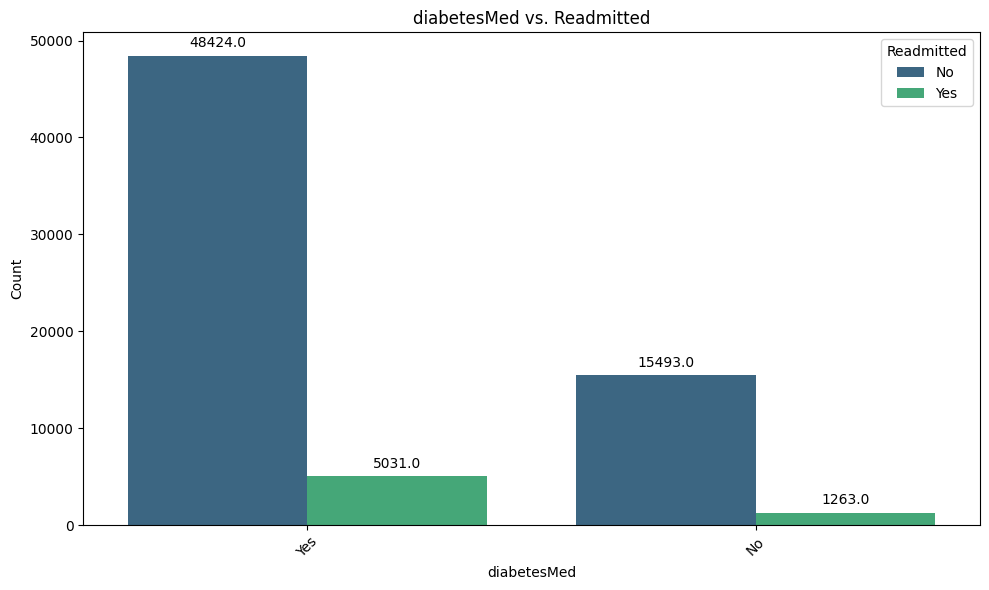

In [19]:
# Filtrar las variables de tipo 'object'
object_variables = data1.select_dtypes(include='object')

# Obtener las variables cualitativas ya codificadas (0 y 1)
qualitative_variables = data1.select_dtypes(include='int64')

# Unir las variables cualitativas y las variables tipo 'object'
merged_data = pd.concat([qualitative_variables, object_variables], axis=1)

# Crear un gráfico de barras agrupadas para cada variable categórica
for col in object_variables.columns:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=merged_data, x=col, hue='readmitted', palette='viridis', order=merged_data[col].value_counts().index)
    plt.title(f'{col} vs. Readmitted')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Readmitted', labels=['No', 'Yes'])
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 9),
                    textcoords='offset points')
    plt.tight_layout()
    plt.show()

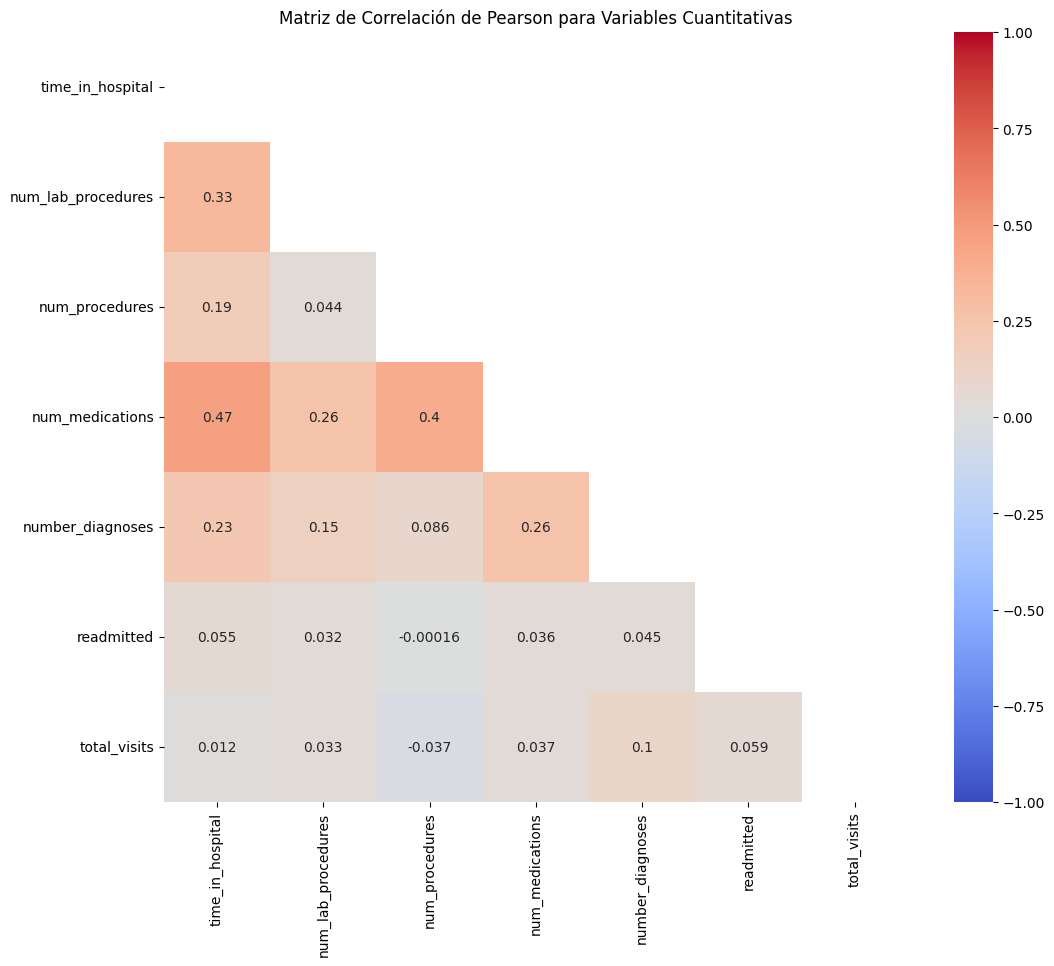

In [20]:
# Filtrar las variables cuantitativas
quantitative_variables = data1.select_dtypes(include='int64')

# Calcular la matriz de correlación de Pearson
correlation_matrix = quantitative_variables.corr()

# Crear una matriz de correlación solo con las variables más correlacionadas
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
tri_corr_matrix = correlation_matrix.mask(mask)

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(tri_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Pearson para Variables Cuantitativas')
plt.show()

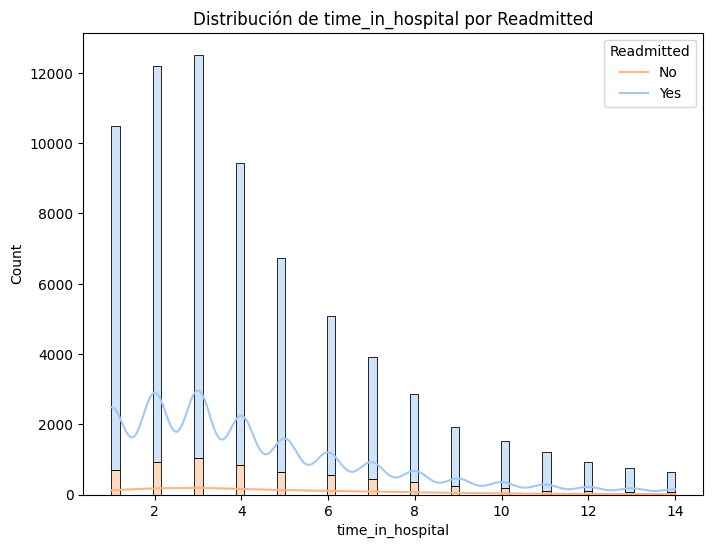

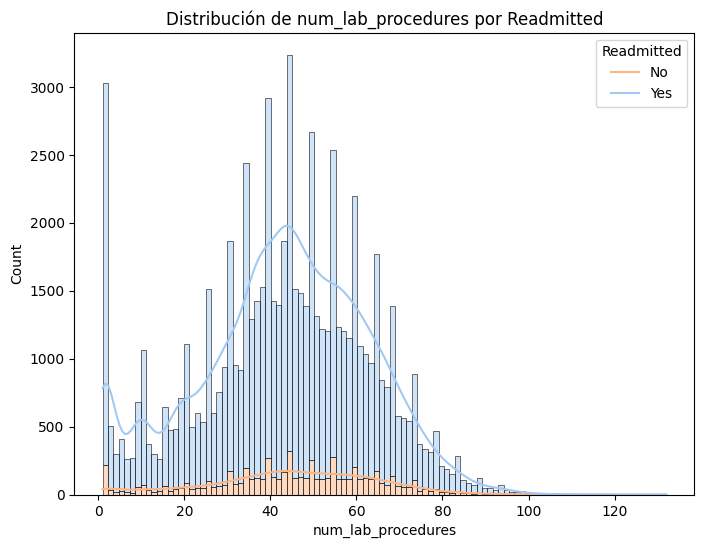

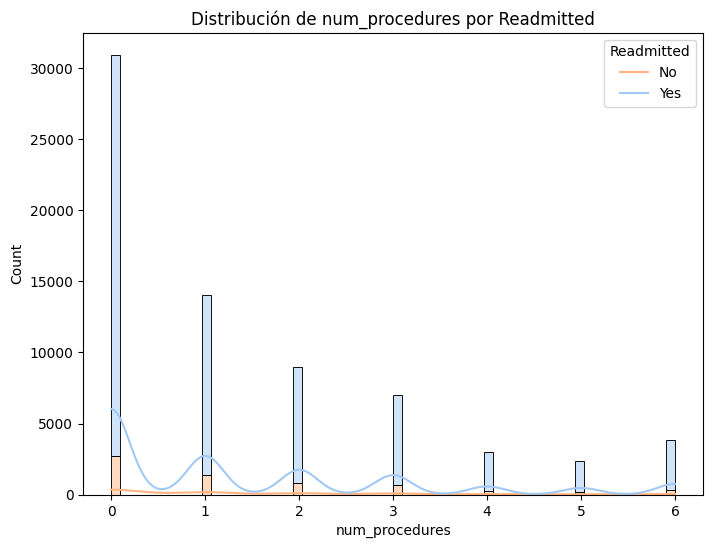

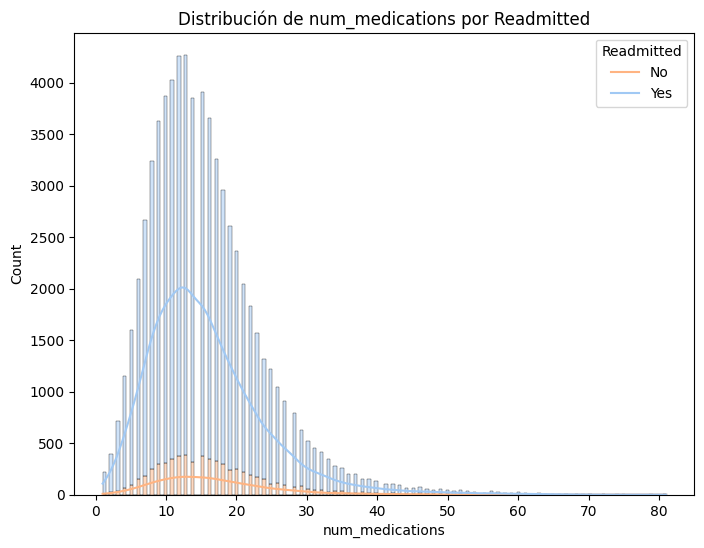

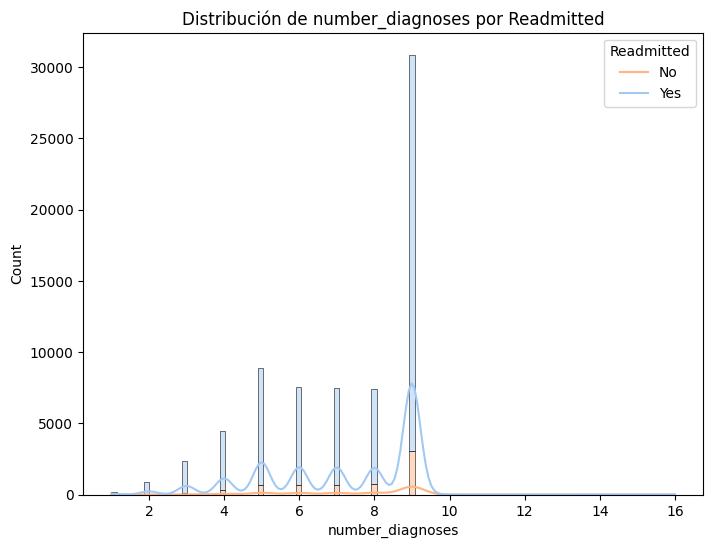

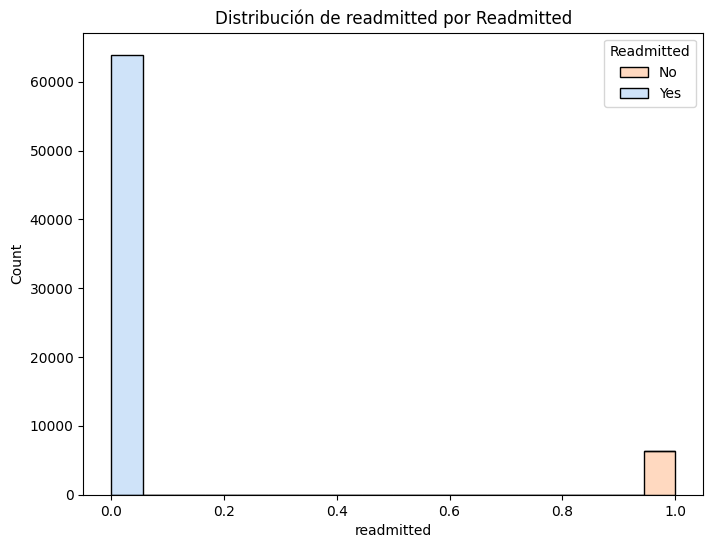

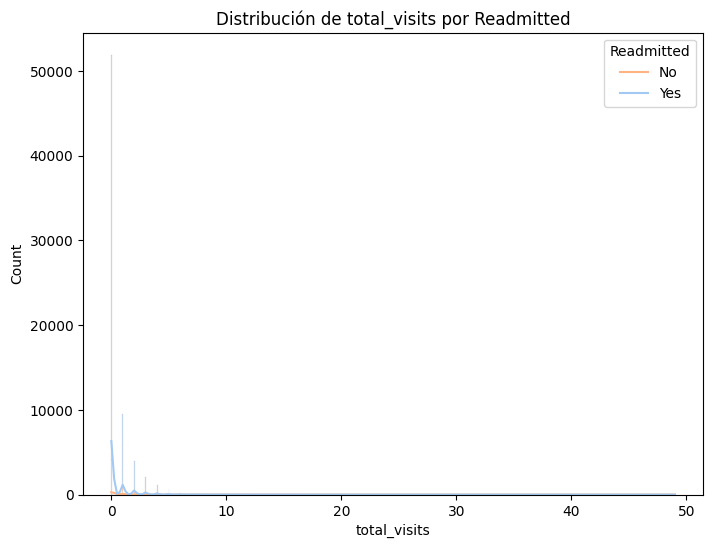

In [22]:
quantitative_variables = data1.select_dtypes(include='int64')

# Crear histogramas para cada variable cuantitativa diferenciando por 'Readmitted'
for col in quantitative_variables.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data1, x=col, hue='readmitted', multiple='stack', kde=True, palette='pastel')
    plt.title(f'Distribución de {col} por Readmitted')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Readmitted', labels=['No', 'Yes'])
    plt.show()

## 3. Preparación de la data 

**3.1 Imputación, one-hot encoding y estandarización**

In [166]:
# Imputar la variable 'race' con la moda
mode_race = data1['race'].mode()[0]
data1['race'].fillna(mode_race, inplace=True)

In [196]:
nombre_archivo = 'df'

# Exporta el DataFrame a un archivo CSV
data1.to_csv(nombre_archivo, index=False)

In [167]:
# Separación en conjunto de datos entrenamiento y testo
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('readmitted', axis = 'columns'),
                                        data1['readmitted'],
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [168]:
# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

In [169]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [170]:
# Convertir el output en dataframe y añadir el nombre de las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
nombre_columnas = np.concatenate([numeric_cols, encoded_cat])
X_train_prep = preprocessor.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=nombre_columnas)
X_train_prep.head(3)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,total_visits,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,glyburide_dosage_change_Si,pioglitazone_dosage_change_No,pioglitazone_dosage_change_Si,rosiglitazone_dosage_change_No,rosiglitazone_dosage_change_Si,acarbose_dosage_change_No,acarbose_dosage_change_Si,miglitol_dosage_change_No,insulin_dosage_change_No,insulin_dosage_change_Si
0,-1.113233,-0.546430,2.606445,-0.803650,0.385540,-0.391691,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,-0.772329,-0.747484,-0.810013,-0.682628,0.887530,0.301918,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.932192,-0.898275,0.328806,0.648619,-0.618441,-0.391691,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [171]:
# Convertir el output en dataframe y añadir el nombre de las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
nombre_columnas = np.concatenate([numeric_cols, encoded_cat])
X_test_prep = preprocessor.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=nombre_columnas)
X_test_prep.head(3)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,total_visits,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,glyburide_dosage_change_Si,pioglitazone_dosage_change_No,pioglitazone_dosage_change_Si,rosiglitazone_dosage_change_No,rosiglitazone_dosage_change_Si,acarbose_dosage_change_No,acarbose_dosage_change_Si,miglitol_dosage_change_No,insulin_dosage_change_No,insulin_dosage_change_Si
0,-1.113233,-1.652227,0.328806,-1.287740,-1.120431,-0.391691,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.591288,0.308050,-0.810013,0.527597,0.887530,4.463571,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-0.431424,-2.104599,-0.810013,-0.440583,-0.116450,0.995527,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


# 4. modelamiento

Para el proceso de modelamiento, se considerarán tres modelos de aprendizaje automático: regresión logística, bosque aleatorio y XGBoost. Dado que la variable de respuesta presenta un desbalanceo de clases, lo que puede influir significativamente en el entrenamiento del modelo al sesgar sus resultados hacia la clase mayoritaria, se exploraron diferentes enfoques para abordar esta situación en cada modelo.<br>

1. Regresión Logística: Se evaluaron tres escenarios distintos. En el primero, se entrenó el modelo con el hiperparámetro class_weight="balanced". En el segundo escenario, se aplicó un submuestreo de la clase mayoritaria, mientras que en el tercero se implementó un sobremuestreo de la clase minoritaria.<br>

2. Bosque Aleatorio: Se realizó una búsqueda exhaustiva de hiperparámetros utilizando la librería GridSearchCV para obtener la configuración óptima del modelo. Luego, se seleccionó el mejor modelo resultante y se aplicaron técnicas de submuestreo y sobremuestreo de la clase para mejorar su desempeño.<br>

3. XGboost: se aplica 

## 4.1 Regresión Logística

### 4.1.1 modelo de regresión class_weight="balanced"

In [172]:
rl_P = LogisticRegression(class_weight="balanced")
rl_P.fit(X_train_prep, y_train)

C:\Users\Jesús\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [173]:
y_pred_p = rl_P.predict(X_test_prep)
confusion_matrix(y_test, y_pred_p)
#plot_confusion_matrix(rl_P, X_test_prep, y_test, values_format='3g')

array([[11794,  7458],
       [  824,   988]], dtype=int64)

In [175]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_p))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74     19252
           1       0.12      0.55      0.19      1812

    accuracy                           0.61     21064
   macro avg       0.53      0.58      0.47     21064
weighted avg       0.86      0.61      0.69     21064



### 4.1.2 Modelo de regresión submuestreo clase maryoritara

In [176]:
under_sampler = RandomUnderSampler()
X_train_res, y_train_res = under_sampler.fit_resample(X_train_prep, y_train)

print ("Distribution antes del submuestreo {}".format(Counter(y_train)))
print ("Distribution despues del submuestreo {}".format(Counter(y_train_res)))

Distribution antes del submuestreo Counter({0: 44665, 1: 4482})
Distribution despues del submuestreo Counter({0: 4482, 1: 4482})


In [177]:
rl_submuestreo = LogisticRegression()
rl_submuestreo.fit(X_train_res, y_train_res)

C:\Users\Jesús\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [178]:
y_pred_submuestreo = rl_submuestreo.predict(X_test_prep)
confusion_matrix(y_test, y_pred_submuestreo)

array([[11754,  7498],
       [  823,   989]], dtype=int64)

In [179]:
print(classification_report(y_test, y_pred_submuestreo))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74     19252
           1       0.12      0.55      0.19      1812

    accuracy                           0.60     21064
   macro avg       0.53      0.58      0.47     21064
weighted avg       0.86      0.60      0.69     21064



### 4.1.3 Modelo de regresión subremuestreo clase minoritaria

In [180]:
os =  RandomOverSampler()
X_train_mas, y_train_mas = os.fit_resample(X_train_prep, y_train)
print ("Distribución antes del sobremuestreo {}".format(Counter(y_train)))
print ("Distribución despues del sobremuestreo {}".format(Counter(y_train_mas)))

Distribución antes del sobremuestreo Counter({0: 44665, 1: 4482})
Distribución despues del sobremuestreo Counter({0: 44665, 1: 44665})


In [181]:
rl_sobremuestreo = LogisticRegression()
rl_sobremuestreo.fit(X_train_mas, y_train_mas)

C:\Users\Jesús\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [182]:
y_pred_sobremuestreo = rl_sobremuestreo.predict(X_test_prep)
confusion_matrix(y_test, y_pred_sobremuestreo)

array([[11838,  7414],
       [  826,   986]], dtype=int64)

In [183]:
print(classification_report(y_test, y_pred_sobremuestreo))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74     19252
           1       0.12      0.54      0.19      1812

    accuracy                           0.61     21064
   macro avg       0.53      0.58      0.47     21064
weighted avg       0.86      0.61      0.69     21064



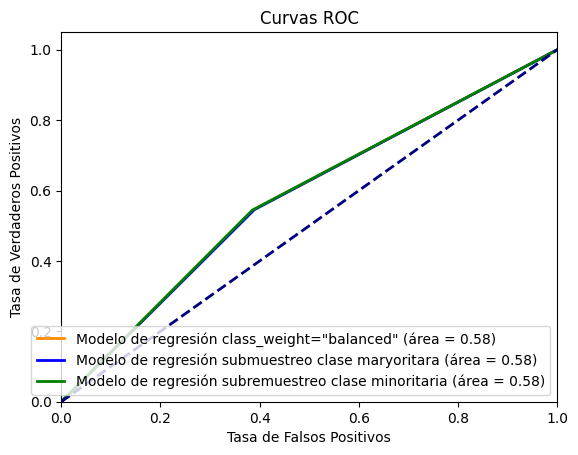

In [184]:
# Calcular las curvas ROC
fpr1, tpr1, _ = roc_curve(y_test, y_pred_p)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_submuestreo)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_pred_sobremuestreo)
roc_auc3 = auc(fpr3, tpr3)

# Graficar las curvas ROC
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Modelo de regresión class_weight="balanced" (área = {:.2f})'.format(roc_auc1))
plt.plot(fpr2, tpr2, color='blue', lw=2, label='Modelo de regresión submuestreo clase maryoritara (área = {:.2f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='green', lw=2, label='Modelo de regresión subremuestreo clase minoritaria (área = {:.2f})'.format(roc_auc3))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

## 4.2 Bosque Aleatorio

In [197]:
bosque = RandomForestClassifier()

parametros = {"criterion": ("gini", "entropy"),
              "n_estimators" : (50, 100, 150),
              'max_depth': (10, 20, 30),
              "max_samples" : (1/3, 2/3),
             'class_weight': ('balanced', 'balanced_subsample')}

#Ejemplos de scoring = "accuracy", "recall", "roc_auc", etc.

rejilla = GridSearchCV(bosque, 
                       parametros, 
                       scoring="roc_auc")

rejilla.fit(X_train_prep, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ('balanced', 'balanced_subsample'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (10, 20, 30),
                         'max_samples': (0.3333333333333333,
                                         0.6666666666666666),
                         'n_estimators': (50, 100, 150)},
             scoring='roc_auc')

In [129]:
rejilla.cv_results_["params"]

[{'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'max_samples': 0.3333333333333333,
  'n_estimators': 50},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'max_samples': 0.3333333333333333,
  'n_estimators': 100},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'max_samples': 0.3333333333333333,
  'n_estimators': 150},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'max_samples': 0.6666666666666666,
  'n_estimators': 50},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'max_samples': 0.6666666666666666,
  'n_estimators': 100},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 10,
  'max_samples': 0.6666666666666666,
  'n_estimators': 150},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 20,
  'max_samples': 0.3333333333333333,
  'n_estimators': 50},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 20,


In [130]:
print(rejilla.cv_results_["rank_test_score"])
print(rejilla.cv_results_["mean_test_score"])
print(rejilla.best_score_)
print(rejilla.best_params_)

[23 17 13 10  2  7 66 44 32 65 62 39 58 31 26 67 46 43 22 20 14  9  6  1
 69 47 49 61 53 51 52 25 27 71 30 37 24 11 12 18  8  4 50 45 33 60 56 40
 64 35 29 72 38 36 15 21 19 16  3  5 54 48 63 68 59 55 57 34 28 70 42 41]
[0.61371615 0.61707254 0.61758134 0.61854154 0.62117298 0.61970659
 0.58587227 0.59249572 0.59559286 0.58639235 0.58680274 0.5932577
 0.58749718 0.59604144 0.60130461 0.5857518  0.59165458 0.59299618
 0.61469738 0.61628041 0.61748984 0.61862964 0.62001805 0.62123047
 0.58382107 0.59053905 0.59005884 0.58702903 0.58916677 0.58978862
 0.58948044 0.60134432 0.60013914 0.58315496 0.59620176 0.59353564
 0.61167174 0.61845148 0.61769432 0.61666696 0.61891998 0.620449
 0.58996523 0.5922371  0.59543146 0.58720973 0.58810767 0.59324562
 0.58642429 0.59484892 0.59995765 0.58068476 0.59350795 0.59479406
 0.61709626 0.61525467 0.61650896 0.61707308 0.62088868 0.6203826
 0.58867214 0.59041382 0.58662207 0.5854838  0.58737468 0.58864008
 0.58801807 0.59497302 0.59996062 0.58338712 0.

In [198]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=123, class_weight= "balanced", criterion= 'entropy', max_depth= 10, max_samples= 0.6666666666666666, n_estimators= 150)
clf.fit(X_train_prep, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_samples=0.6666666666666666,
                       n_estimators=150, random_state=123)

In [199]:
y_pred_clf = clf.predict(X_test_prep)
confusion_matrix(y_test, y_pred_clf)

array([[13390,  5862],
       [  980,   832]], dtype=int64)

In [200]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     19252
           1       0.12      0.46      0.20      1812

    accuracy                           0.68     21064
   macro avg       0.53      0.58      0.50     21064
weighted avg       0.86      0.68      0.74     21064



### 4.2.1 Modelo de bosque aleatorio submuestreo clase maryoritara

In [201]:
clf_submuestreo = RandomForestClassifier(random_state=123, class_weight= "balanced", criterion= 'entropy', max_depth= 10, max_samples= 0.3333333333333333, n_estimators= 150)
clf_submuestreo.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_samples=0.3333333333333333,
                       n_estimators=150, random_state=123)

In [202]:
y_pred_submuestreo_clf = clf_submuestreo.predict(X_test_prep)
confusion_matrix(y_test, y_pred_submuestreo_clf)

array([[11209,  8043],
       [  775,  1037]], dtype=int64)

In [203]:
print(classification_report(y_test, y_pred_submuestreo_clf))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72     19252
           1       0.11      0.57      0.19      1812

    accuracy                           0.58     21064
   macro avg       0.52      0.58      0.45     21064
weighted avg       0.86      0.58      0.67     21064



### 4.2.2 Modelo de regresión subremuestreo clase minoritaria

In [204]:
clf_sobremuestreo = RandomForestClassifier(random_state=123, class_weight= "balanced", criterion= 'entropy', max_depth= 10, max_samples= 0.3333333333333333, n_estimators= 150)
clf_sobremuestreo.fit(X_train_mas, y_train_mas)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_samples=0.3333333333333333,
                       n_estimators=150, random_state=123)

In [205]:
y_pred_sobremuestreo_clf = clf_sobremuestreo.predict(X_test_prep)
confusion_matrix(y_test, y_pred_sobremuestreo_clf)

array([[12505,  6747],
       [  861,   951]], dtype=int64)

In [206]:
print(classification_report(y_test, y_pred_sobremuestreo_clf))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     19252
           1       0.12      0.52      0.20      1812

    accuracy                           0.64     21064
   macro avg       0.53      0.59      0.48     21064
weighted avg       0.87      0.64      0.72     21064



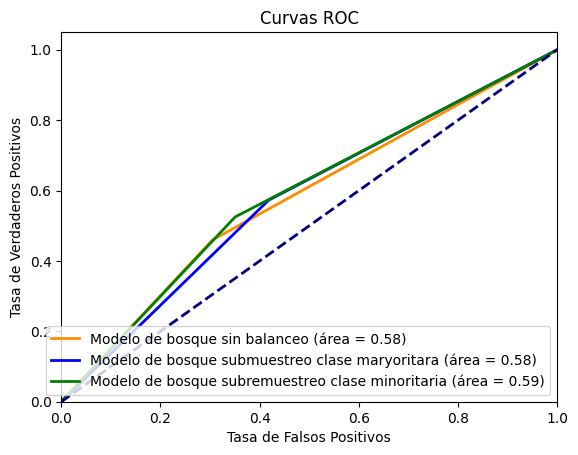

In [207]:
# Calcular las curvas ROC
fpr1, tpr1, _ = roc_curve(y_test, y_pred_clf)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_submuestreo_clf)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_pred_sobremuestreo_clf)
roc_auc3 = auc(fpr3, tpr3)

# Graficar las curvas ROC
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Modelo de bosque sin balanceo (área = {:.2f})'.format(roc_auc1))
plt.plot(fpr2, tpr2, color='blue', lw=2, label='Modelo de bosque submuestreo clase maryoritara (área = {:.2f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='green', lw=2, label='Modelo de bosque subremuestreo clase minoritaria (área = {:.2f})'.format(roc_auc3))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

# 6. Despliegue del modelo

En total, se ejecutaron 6 modelos, como se observa en la sección anterior. Estos modelos mostraron un rendimiento relativamente positivo en relación a las soluciones aplicadas para abordar el desbalanceo de clases. En esta sección, se llevará a cabo un análisis detallado de la robustez del modelo seleccionado, centrándose en aspectos como la validación cruzada y la curva de aprendizaje, entre otros.  

In [218]:
# Definir la métrica de recall como la métrica a evaluar
recall_metric = make_scorer(recall_score)

# Realizar validación cruzada y calcular la métrica para cada fold (por defecto, utiliza 5-fold)
scores = cross_val_score(clf_submuestreo, X_train_res, y_train_res, cv=5, scoring=recall_metric)

scores

array([0.62388393, 0.63727679, 0.58751394, 0.58528428, 0.59598214])

**Rendimiento Aceptable**: El rendimiento del modelo, evaluado a través de la validación cruzada, muestra un nivel aceptable de precisión. Con una media de aproximadamente 0.626, indica que el modelo es capaz de predecir con una precisión razonable si una persona será readmitida o no.<br>

**Consistencia**: La consistencia en los puntajes de validación cruzada, con una desviación estándar relativamente baja, indica que el modelo está aprendiendo de manera consistente en diferentes subconjuntos de datos y no es demasiado sensible a la elección particular de los datos de entrenamiento.<br>

**Posible Margen de Mejora**: Aunque el rendimiento es aceptable, aún existe un margen de mejora. Sería beneficioso investigar y aplicar estrategias para mejorar este rendimiento, lo que podría involucrar el ajuste de hiperparámetros del modelo, la selección de características más relevantes o incluso considerar modelos más complejos.<br>

**Relevancia Clínica**: Para evaluar completamente el valor clínico del modelo, es crucial considerar la relevancia de la predicción en el contexto médico. Es importante que el modelo tenga un impacto significativo y útil en la predicción de la readmisión de pacientes con diabetes, lo que puede traducirse en una mejora en la atención al paciente y en la eficiencia del sistema de salud.<br>

En resumen, aunque el modelo tiene un rendimiento aceptable, existe un espacio para mejoras adicionales para garantizar una mayor precisión en la predicción de la readmisión de pacientes con diabetes. La relevancia clínica y la utilidad práctica del modelo también deben ser consideradas en futuros análisis.

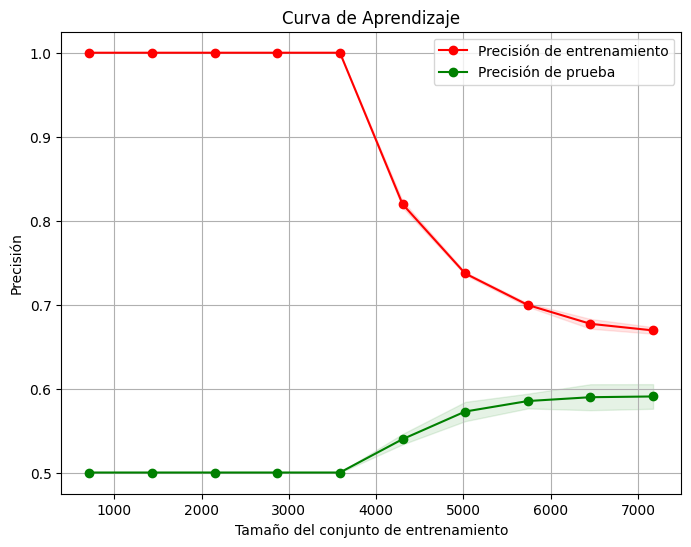

In [219]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title('Curva de Aprendizaje')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Precisión')
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Precisión de entrenamiento')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Precisión de prueba')
    plt.legend(loc='best')
    plt.show()

# Trazar la curva de aprendizaje después de entrenar el modelo
plot_learning_curve(clf_submuestreo, X_train_res, y_train_res)

Aunque ambas curvas no se tocan, se observa que la precisión en el conjunto de entrenamiento es mayor que la precisión en el conjunto de validación a lo largo de diferentes tamaños de conjuntos de entrenamiento. Esto sugiere que el modelo tiene una buena capacidad de aprendizaje y generalización, ya que su desempeño en datos no vistos (conjunto de validación) no decae significativamente incluso a medida que se aumenta el tamaño del conjunto de entrenamiento.

en conclusión, la curva de aprendizaje ilustra cómo varía la precisión del modelo a medida que se aumenta el tamaño del conjunto de entrenamiento y proporciona información valiosa sobre el rendimiento y la capacidad de generalización del modelo.

# Cosideraciones éticas

En este documento, se han incorporado algunos códigos provenientes de diversas páginas web. No obstante, es importante destacar que muchos de estos códigos fueron adaptados específicamente para cumplir con los objetivos particulares de este proyecto. Se subraya que las ideas propuestas para abordar los desafíos planteados son de mi autoría.